# Exploratory analysis

Study title: Increased normalized lactate load is associated with higher mortality in both sepsis and non-sepsis patients: an analysis of the MIMIC-IV database

DOI: https://doi.org/10.1186/s12871-022-01617-5

This notebook provides insights into the data analyzed for the given study.

The objective of the study was: To evaluate the association between normalized lactate load, an index that incorporates the magnitude of change and the time interval of such evolution of lactate, and 28-day mortality in sepsis and non-sepsis patients.

## Import libraries

In [1]:
# Import libraries
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sweetviz as sv
from tableone import TableOne

import warnings
warnings.filterwarnings('ignore')

# local package - can be useful to put misc utilities into a file in the same folder
# import utils

Next we load in the generated tables.

In [2]:
data_path = Path(f'../data/')
os.chdir(data_path)

cohort = pd.read_csv('cohort.csv')
comorbidities = pd.read_csv('comorbidities.csv')
labs = pd.read_csv('labs.csv')
lactate = pd.read_csv('lactate.csv')
lactateload = pd.read_csv('lactateload.csv')
main = pd.read_csv('main.csv')
mortality = pd.read_csv('mortality.csv')
vitalsigns = pd.read_csv('vitalsigns.csv')


## Explore the dataset.

* Investigate exclusions, consistency with published results
* Examine data, find any outliers
* Test missing data methods
* Vary data extraction protocols (time window, aggregation)
* Visualize data, ensure it is appropriate for the study

In [3]:
display(cohort.head())
display(comorbidities.head())
display(labs.head())
display(lactate.head())
display(lactateload.head())
display(main.head())
display(mortality.head())
display(vitalsigns.head())

,subject_id,hadm_id,stay_id,exclusion_non_adult,exclusion_readmission,exclusion_one_lactate_measurement,exclusion_short_icu_stay,sepsis
0,10001884,26184834,37510196,0,0,0,0,1
1,10002013,23581541,39060235,0,0,0,0,0
2,10002155,20345487,32358465,0,0,0,1,0
3,10002428,20321825,34807493,0,1,0,0,1
4,10002428,23473524,35479615,0,1,0,0,1


,subject_id,hadm_id,congestive_heart_failure,myocardial_infarction,cerebrovascular_disease,chronic_pulmonary_disease,mild_liver_disease,severe_liver_disease,diabetes_without_complication,diabetes_with_complication,renal_disease
0,10000019,25058216,0,0,0,0,0,0,0,0,0
1,10000032,22595853,0,0,0,0,0,0,0,0,0
2,10000032,22841357,0,0,0,0,0,0,0,0,0
3,10000032,25742920,0,0,0,0,0,0,0,0,0
4,10000032,29079034,0,0,0,0,0,0,0,0,0


,subject_id,hadm_id,stay_id,max_anion_gap,min_albumin,max_bilirubin,max_creatinine,max_glucose,min_hemoglobin,min_platelet,max_potassium,max_pt,max_sodium,min_sodium,max_blood_urea_nitrogen,max_wbc_count
0,10000032,29079034,39553978,14.0,3.8,2.7,0.5,115.0,11.9,94.0,5.0,19.5,132.0,130.0,33.0,4.1
1,10000980,26913865,39765666,17.0,NaN,NaN,2.2,144.0,10.1,217.0,4.2,14.5,139.0,139.0,38.0,5.4
2,10001217,24597018,37067082,15.0,NaN,NaN,0.4,113.0,11.2,285.0,3.6,12.6,138.0,138.0,9.0,19.0
3,10001217,27703517,34592300,13.0,NaN,NaN,0.5,113.0,12.3,299.0,4.3,12.4,139.0,139.0,10.0,8.4
4,10001725,25563031,31205490,16.0,NaN,NaN,0.8,152.0,12.6,299.0,3.9,11.3,140.0,138.0,18.0,20.1


,subject_id,hadm_id,stay_id,max_lactate,mean_lactate
0,10001884,26184834,37510196,1.5,1.300000
1,10002013,23581541,39060235,3.1,2.833333
2,10002155,20345487,32358465,7.7,5.933333
3,10002428,20321825,34807493,0.9,0.850000
4,10002428,23473524,35479615,1.5,1.100000


,subject_id,hadm_id,stay_id,lactate,time,n
0,10001884,26184834,37510196,1.5,2,1
1,10001884,26184834,37510196,1.1,7,2
2,10002013,23581541,39060235,2.8,1,1
3,10002013,23581541,39060235,3.1,2,2
4,10002013,23581541,39060235,2.6,3,3


,subject_id,hadm_id,stay_id,age,gender,weight,sofa_score,sapsii_score,length_of_hospital_stay,length_of_icu_stay,daily_urine_output
0,10000032,29079034,39553978,52,F,39.4,10,38,2,0,175.0
1,10000980,26913865,39765666,73,F,76.2,2,30,6,0,3900.0
2,10001217,24597018,37067082,55,F,71.2,0,13,7,1,2645.0
3,10001217,27703517,34592300,55,F,74.8,1,22,6,1,2475.0
4,10001725,25563031,31205490,46,F,72.2,1,23,3,1,1965.0


,subject_id,hadm_id,died_in_28_days
0,10000019,25058216,0
1,10000032,22595853,0
2,10000032,22841357,0
3,10000032,25742920,0
4,10000032,29079034,0


,subject_id,hadm_id,stay_id,mean_heart_rate,min_systolic_bp,min_diastolic_bp,min_mean_arterial_bp,max_respiratory_rate,min_pulse_saturation
0,10000032,29079034,39553978,97.625000,NaN,NaN,NaN,23.0,16.0
1,10000980,26913865,39765666,73.300000,NaN,NaN,NaN,27.0,14.0
2,10001217,24597018,37067082,93.173913,NaN,NaN,NaN,27.0,13.0
3,10001217,27703517,34592300,78.916667,NaN,NaN,NaN,22.0,13.0
4,10001725,25563031,31205490,80.347826,NaN,NaN,NaN,21.0,13.0


In [4]:
def get_exclusions(df, verbose=True):
    """
    Get all exclusions, assuming columns begin with the word exclusion.
    
    Returns an index of stays to *keep* in the study.
    """
    N = df.shape[0]
    idx = df.index.notnull()
    cols = [c for c in df.columns if c.startswith('exclusion')]

    if verbose:
        print(f'{N} stays')

    # remove excluded patients
    for c in cols:
        idxExcl = df[c] == 1
        n_excl = (idx & idxExcl).sum()
        frac = n_excl / N * 100.0
        if verbose:
            print(f'  {n_excl:5d} / {N:5d} ({frac:3.1f}%) - {c}')
        idx = idx & ~idxExcl
        N = idx.sum()
    
    return idx

In [5]:
idx = get_exclusions(cohort)
# create a "co" dataframe with only the hadm_id we intend to keep
co = cohort.loc[idx, ['subject_id','hadm_id','stay_id', 'sepsis']].copy().reset_index(drop=True)
print(co.shape)
co.head()

39642 stays
      0 / 39642 (0.0%) - exclusion_non_adult
   8435 / 39642 (21.3%) - exclusion_readmission
  12294 / 31207 (39.4%) - exclusion_one_lactate_measurement
   1487 / 18913 (7.9%) - exclusion_short_icu_stay
(17426, 4)


,subject_id,hadm_id,stay_id,sepsis
0,10001884,26184834,37510196,1
1,10002013,23581541,39060235,0
2,10002428,28662225,33987268,0
3,10002443,21329021,35044219,1
4,10002495,24982426,36753294,0


In [6]:
# Calculate lactate load and normalized lactate load
ll = lactateload.groupby('stay_id') 
lactate_load = []
normalized_lactate_load = []
stay_id = []

for group, item in ll:
  _sum = 0
  for v1, v2, n1, n2, t1, t2 in zip(ll.get_group(group)['lactate'], ll.get_group(group)['lactate'][1:], ll.get_group(group)['n'],
                                    ll.get_group(group)['n'][1:], ll.get_group(group)['time'], ll.get_group(group)['time'][1:]):
    if n1 == 1:
      _sum += (((v1+v1)/2)*(t1-0))
    if n2 == ll.get_group(group)['n'].iloc[-1]:
      _sum += (((v2+v2)/2)*(24-t2))
    _sum += (((v1+v2)/2)*(t2-t1))
    
  stay_id.append(group)
  lactate_load.append(_sum)
  normalized_lactate_load.append(_sum/24)

new_lactate_load = pd.DataFrame({'stay_id': stay_id, 'lactate_load': lactate_load, 'normalized_lactate_load': normalized_lactate_load})

In [7]:
# Merge all the dataframes into one
df = pd.merge(co, main, how='left', on=['subject_id','hadm_id','stay_id']) \
       .merge(mortality, how='left', on=['subject_id','hadm_id']) \
       .merge(comorbidities, how='left', on=['subject_id','hadm_id']) \
       .merge(labs, how='left', on=['subject_id','hadm_id','stay_id']) \
       .merge(vitalsigns, how='left', on=['subject_id','hadm_id','stay_id']) \
       .merge(lactate, how='left', on=['subject_id','hadm_id','stay_id']) \
       .merge(new_lactate_load, how='left', on='stay_id')

print(df.shape)
df

(17426, 45)


,subject_id,hadm_id,stay_id,sepsis,age,gender,weight,sofa_score,sapsii_score,length_of_hospital_stay,...,mean_heart_rate,min_systolic_bp,min_diastolic_bp,min_mean_arterial_bp,max_respiratory_rate,min_pulse_saturation,max_lactate,mean_lactate,lactate_load,normalized_lactate_load
0,10001884,26184834,37510196,1,68,F,65.0,8,44,13,...,72.423077,NaN,NaN,NaN,26.0,0.0,1.5,1.300000,28.20,1.175000
1,10002013,23581541,39060235,0,53,F,96.0,4,32,5,...,94.619048,88.0,50.0,41.0,23.0,0.0,3.1,2.833333,63.20,2.633333
2,10002428,28662225,33987268,0,80,F,NaN,2,46,17,...,110.562500,NaN,NaN,NaN,34.0,18.0,2.4,1.825000,43.95,1.831250
3,10002443,21329021,35044219,1,53,M,156.1,4,28,3,...,94.703704,NaN,NaN,NaN,30.0,16.0,1.9,1.800000,44.30,1.845833
4,10002495,24982426,36753294,0,81,M,64.1,4,47,7,...,105.342857,NaN,NaN,NaN,28.0,16.0,4.4,3.666667,86.30,3.595833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17421,19997843,20277361,32880062,1,47,M,70.0,11,29,11,...,79.521739,NaN,NaN,NaN,35.0,0.0,1.3,1.100000,24.20,1.008333
17422,19997886,20793010,37403074,1,67,M,62.2,10,48,28,...,91.869565,NaN,NaN,NaN,27.0,14.0,3.7,3.400000,81.50,3.395833
17423,19998591,24349193,36794489,1,52,F,49.4,10,44,31,...,96.629630,NaN,NaN,NaN,27.0,9.0,1.7,1.500000,35.40,1.475000
17424,19998843,24842066,30988867,0,45,M,90.0,10,60,3,...,87.050000,NaN,NaN,71.0,29.0,0.0,2.8,2.020000,57.25,2.385417


In [8]:
pd.set_option('display.max_columns', None)

# remove the identifiers to simplify analysis
data = df.loc[:, ~df.columns.isin(['subject_id','hadm_id','stay_id'])]

# remove outliers and implausible values
data['weight'] = np.where(data['weight'] < 10, np.nan, data['weight'])
data['daily_urine_output'] = np.where( (data['daily_urine_output'] < 10) | (data['daily_urine_output'] > 20000), np.nan, data['daily_urine_output'])
data['min_systolic_bp'] = np.where(data['min_systolic_bp'] < 5, np.nan, data['min_systolic_bp'])
data['min_diastolic_bp'] = np.where(data['min_diastolic_bp'] < 5, np.nan, data['min_diastolic_bp'])
data['min_mean_arterial_bp'] = np.where(data['min_mean_arterial_bp'] < 5, np.nan, data['min_mean_arterial_bp'])
data['max_respiratory_rate'] = np.where(data['max_respiratory_rate'] > 1000, np.nan, data['max_respiratory_rate'])

data.groupby('sepsis').describe()

age                                                       weight  \
          count       mean        std   min   25%   50%   75%   max    count   
sepsis                                                                         
0       11544.0  63.519837  15.793224  18.0  55.0  65.0  75.0  91.0  11179.0   
1        5882.0  65.071744  15.922048  18.0  55.0  66.0  77.0  91.0   5713.0   

                                                            sofa_score  \
             mean        std   min   25%   50%   75%    max      count   
sepsis                                                                   
0       84.292611  22.825447  28.2  69.0  81.4  96.0  345.0    11544.0   
1       82.647086  25.204769  24.0  65.7  78.8  95.0  275.0     5882.0   

                                                      sapsii_score             \
            mean       std  min  25%  50%   75%   max        count       mean   
sepsis                                                                          
0       6.652374  3.854968  0.0  4.0  6.0   9.0  23.0      11544.0  39.620409   
1       8.272356  3.938174  1.0  5.0  8.0  11.0  23.0       5882.0  44.038932   

                                                length_of_hospital_stay  \
              std  min   25%   50%   75%    max                   count   
sepsis                                                                    
0       14.450016  0.0  30.0  38.0  48.0  114.0                 11544.0   
1       14.819954  6.0  34.0  42.0  53.0  108.0                  5882.0   

                                                         length_of_icu_stay  \
             mean        std  min  25%  50%   75%    max              count   
sepsis                                                                        
0       12.201057  12.743698  0.0  5.0  9.0  14.0  378.0            11544.0   
1       13.522951  15.478962  0.0  6.0  9.0  16.0  467.0             5882.0   

                                                      daily_urine_output  \
            mean       std  min  25%  50%  75%    max              count   
sepsis                                                                     
0       4.823112  6.346985  1.0  1.0  3.0  5.0  100.0            11316.0   
1       5.467358  6.312125  1.0  2.0  3.0  6.0   79.0             5734.0   

                                                                         \
               mean          std   min     25%     50%     75%      max   
sepsis                                                                    
0       1881.958819  1287.792537  10.0  1050.0  1630.0  2410.0  19485.0   
1       1674.904726  1294.872712  10.0   800.0  1400.0  2215.0  14490.0   

       died_in_28_days                                               \
                 count      mean       std  min  25%  50%  75%  max   
sepsis                                                                
0              11544.0  0.117983  0.322602  0.0  0.0  0.0  0.0  1.0   
1               5882.0  0.190751  0.392927  0.0  0.0  0.0  0.0  1.0   

       congestive_heart_failure                                               \
                          count      mean       std  min  25%  50%  75%  max   
sepsis                                                                         
0                       11540.0  0.265165  0.441440  0.0  0.0  0.0  1.0  1.0   
1                        5876.0  0.285228  0.451561  0.0  0.0  0.0  1.0  1.0   

       myocardial_infarction                                               \
                       count      mean       std  min  25%  50%  75%  max   
sepsis                                                                      
0                    11540.0  0.188995  0.391521  0.0  0.0  0.0  0.0  1.0   
1                     5876.0  0.147039  0.354175  0.0  0.0  0.0  0.0  1.0   

       cerebrovascular_disease                                               \
                         count      mean       std  min  25%  50%  75%  max   
seps

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:02 -> (00:00 left)



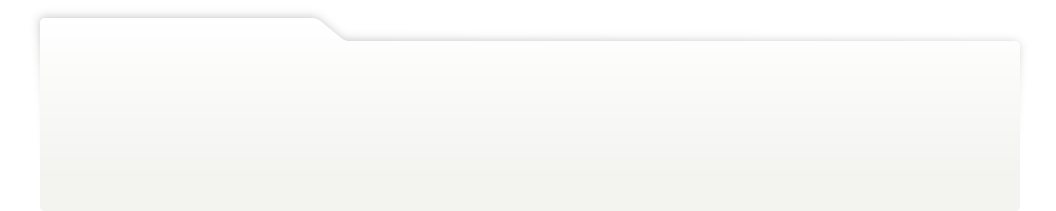
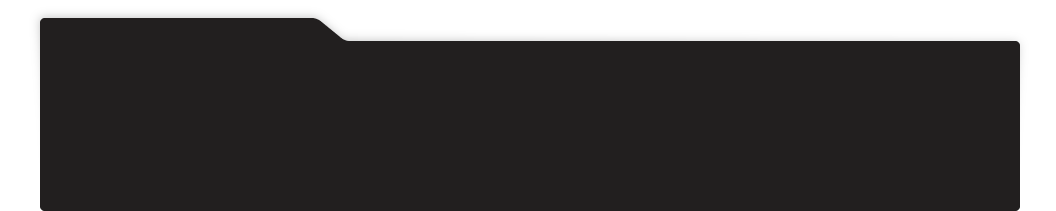
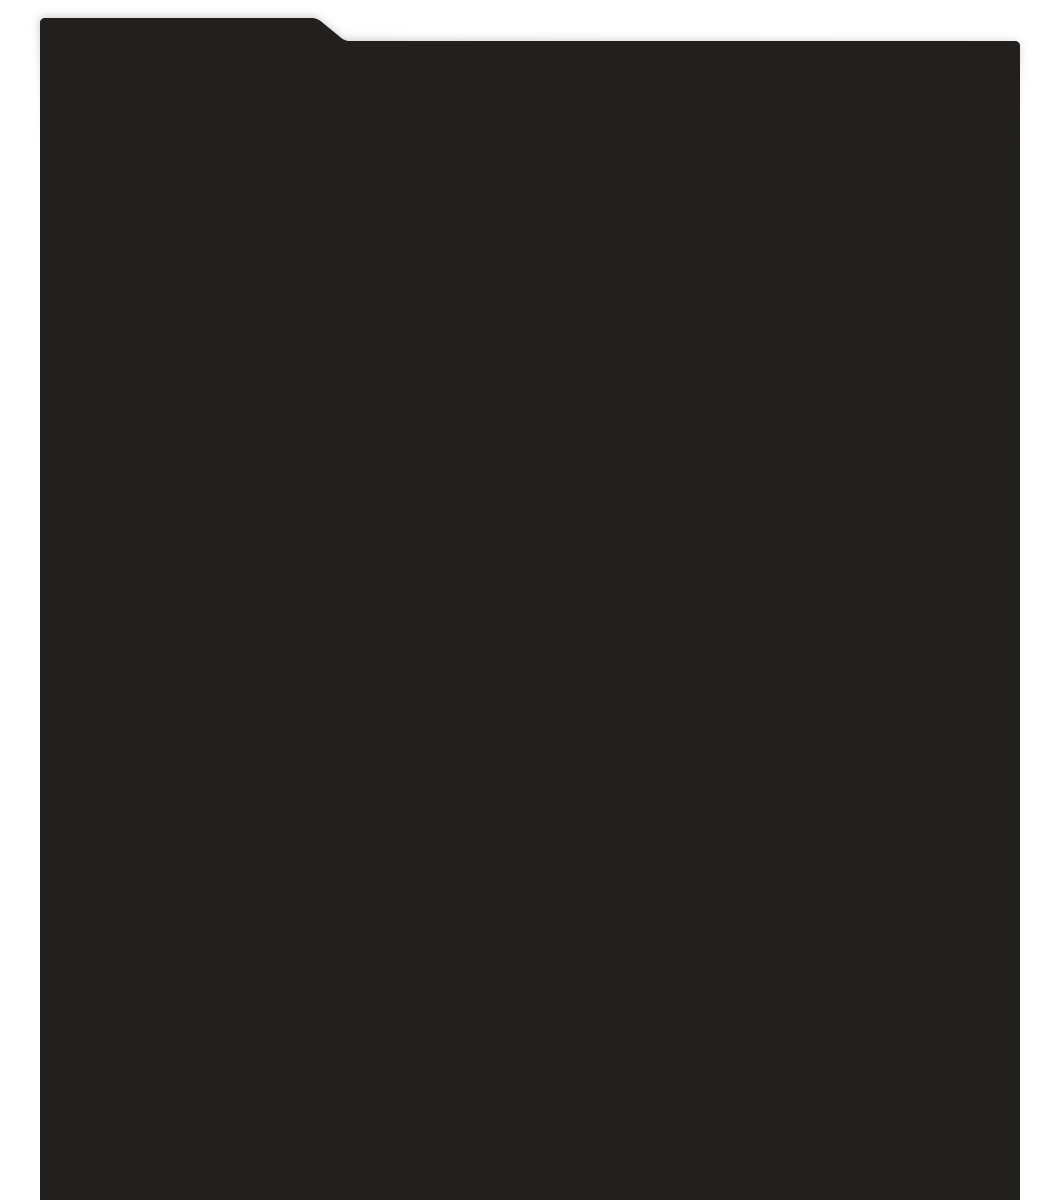
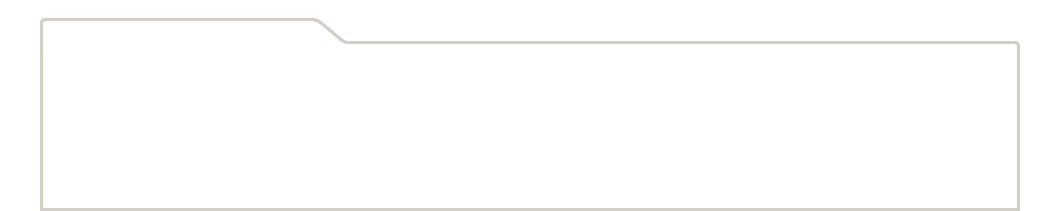
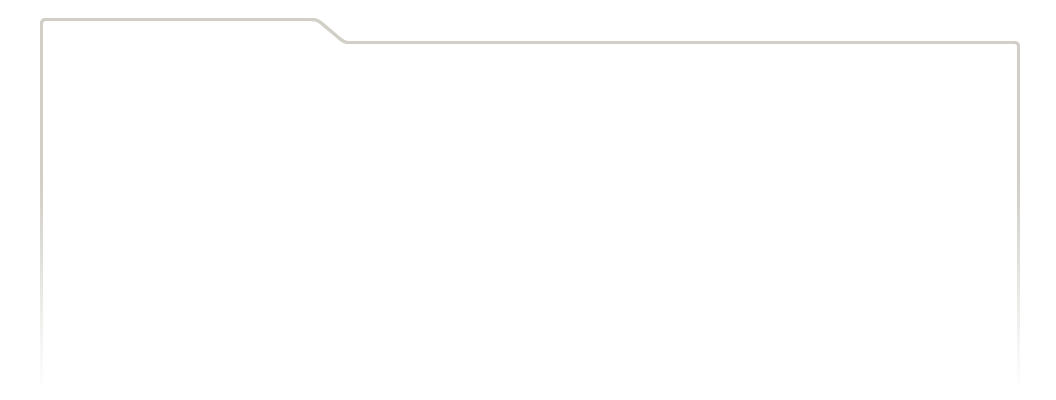
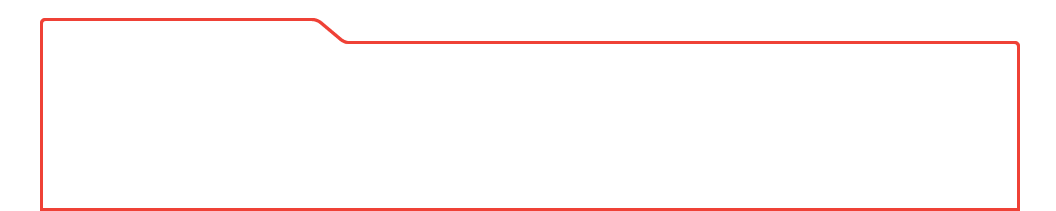
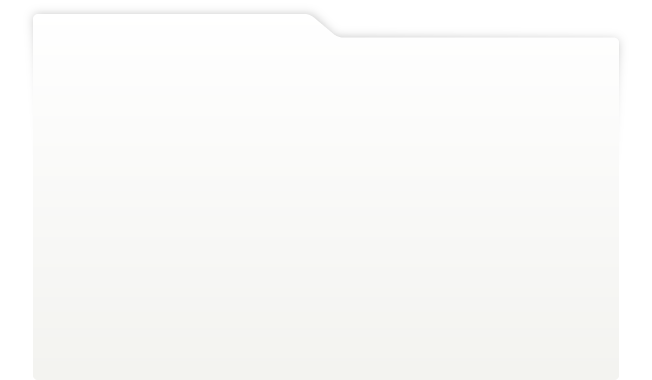
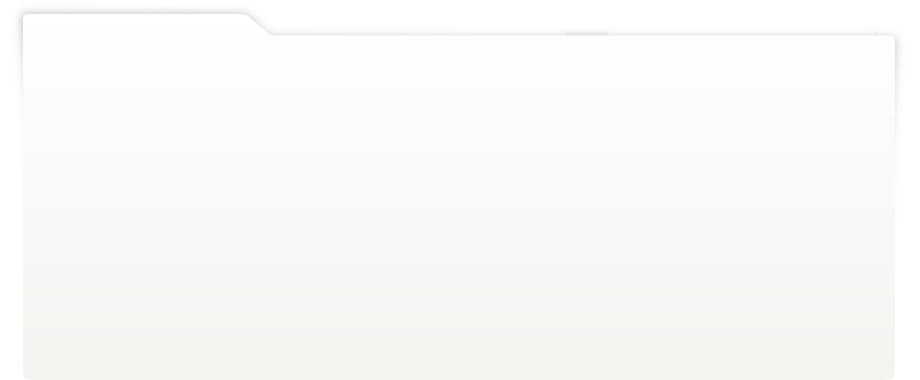
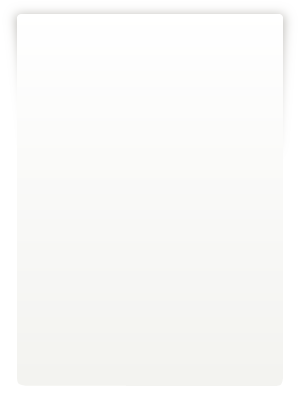
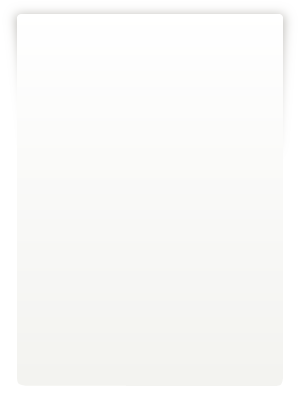
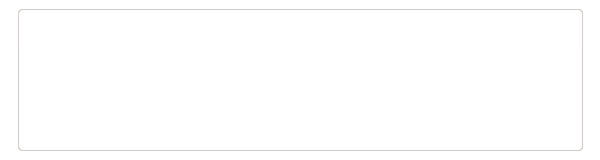
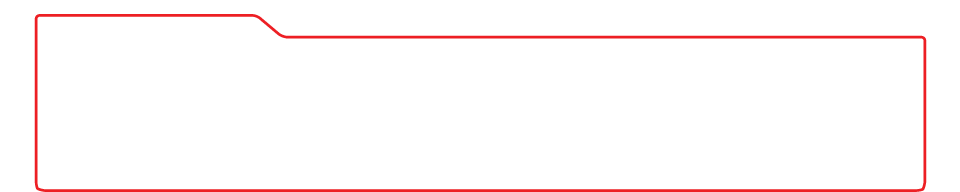
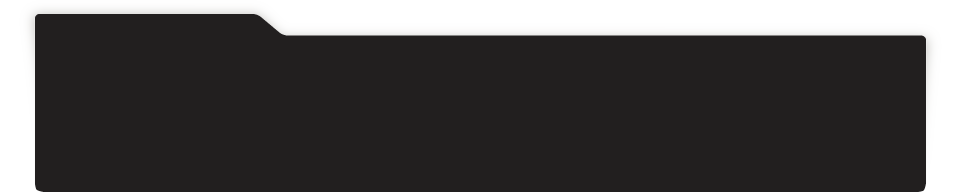
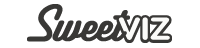
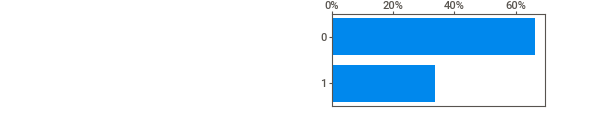
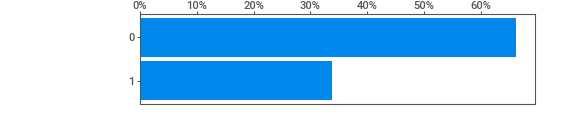
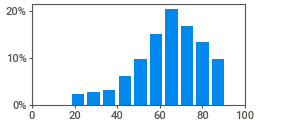
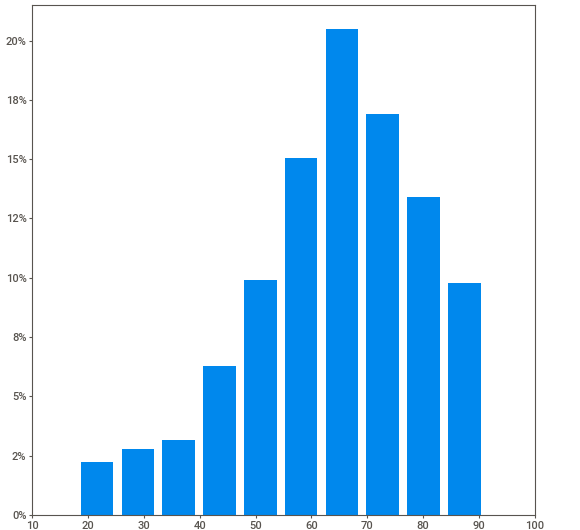
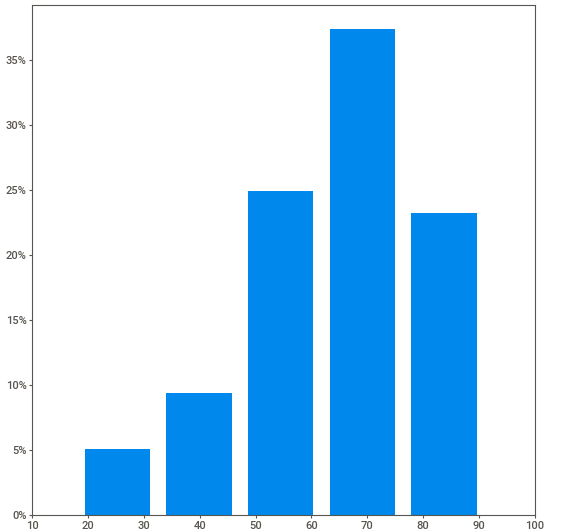
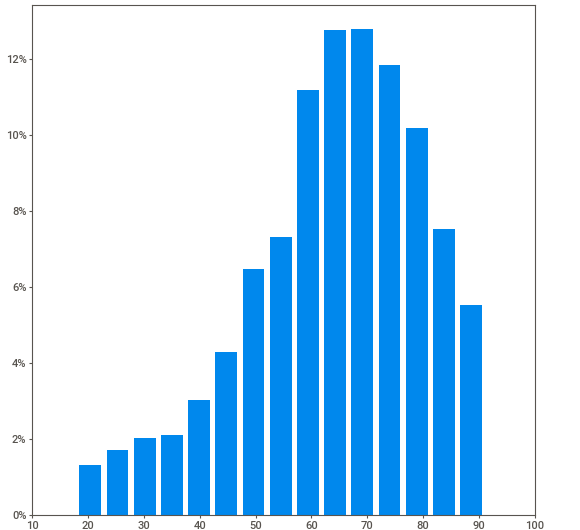
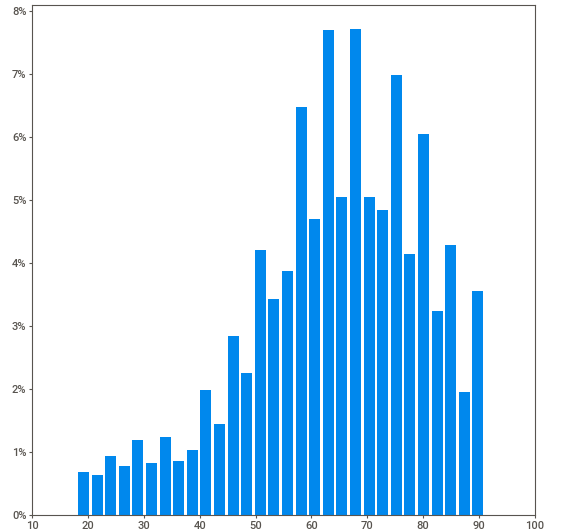
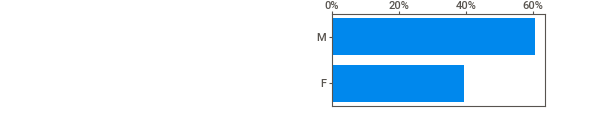
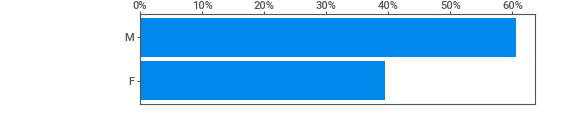
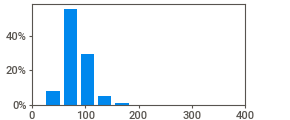
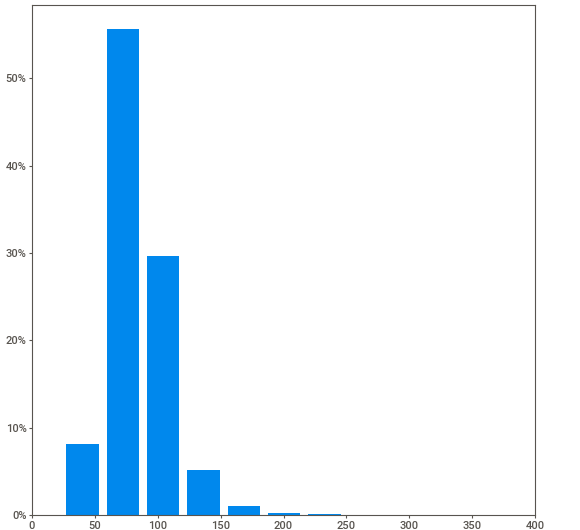
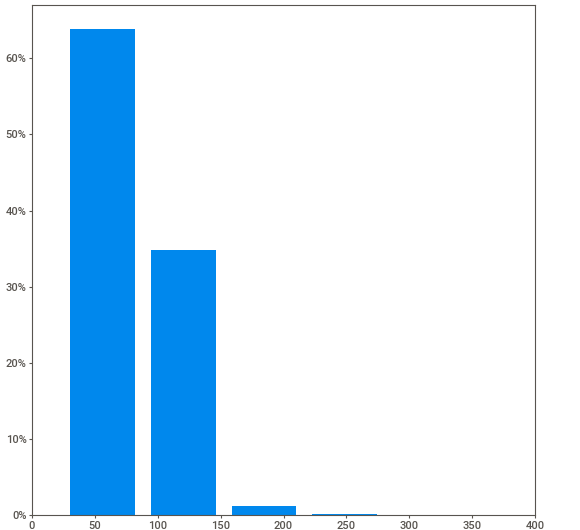
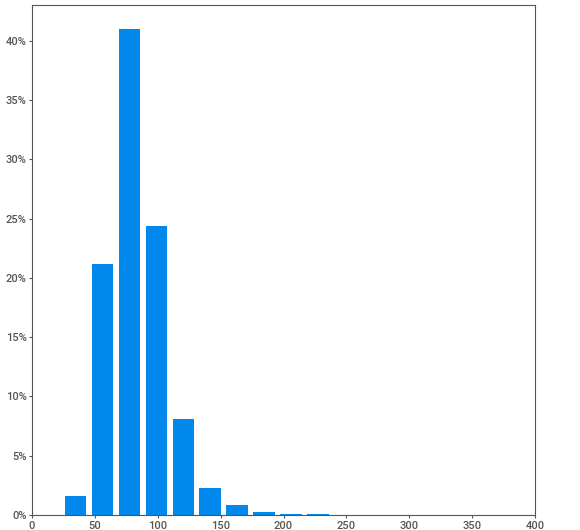
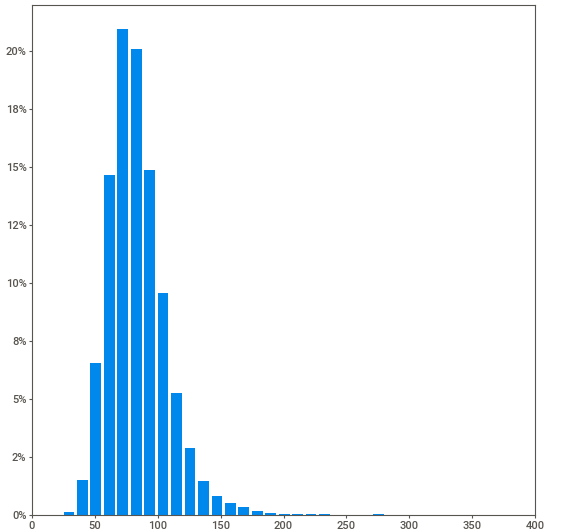
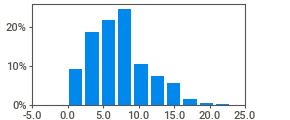
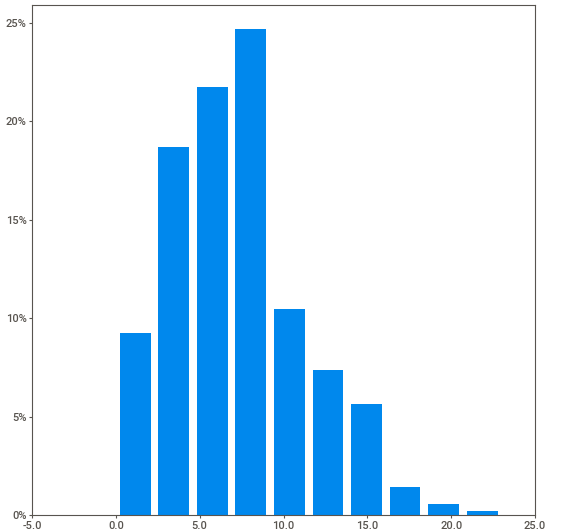
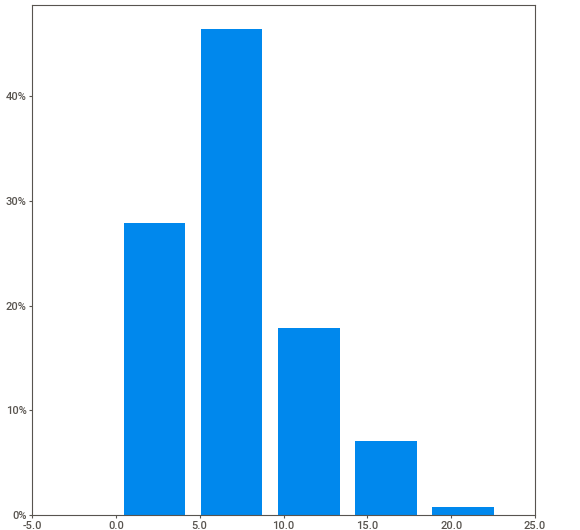
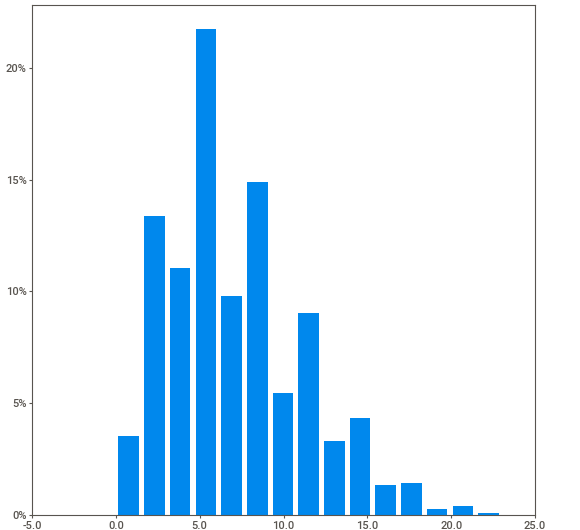
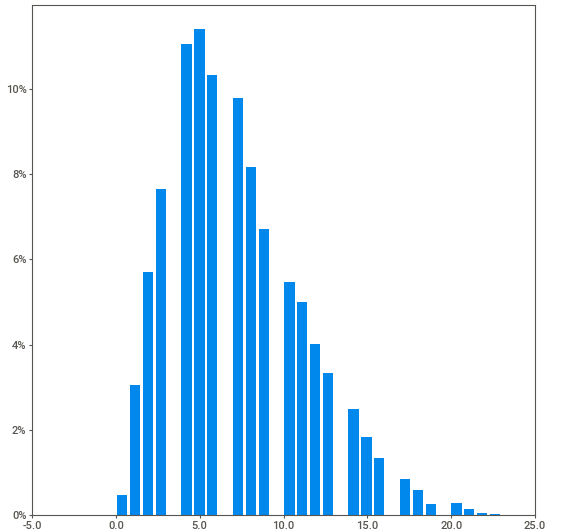
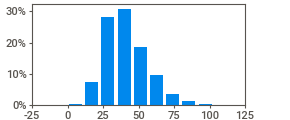
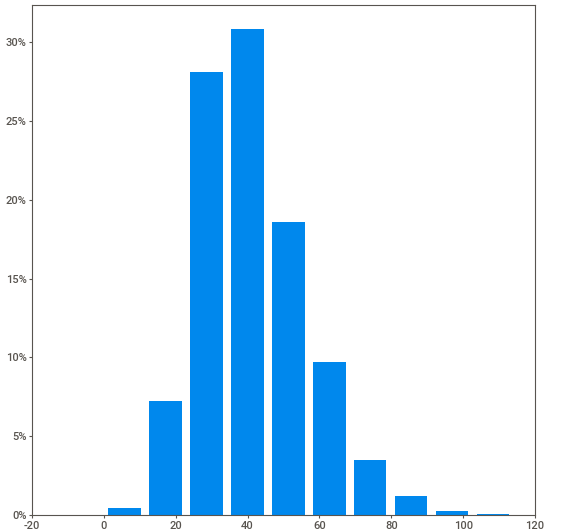
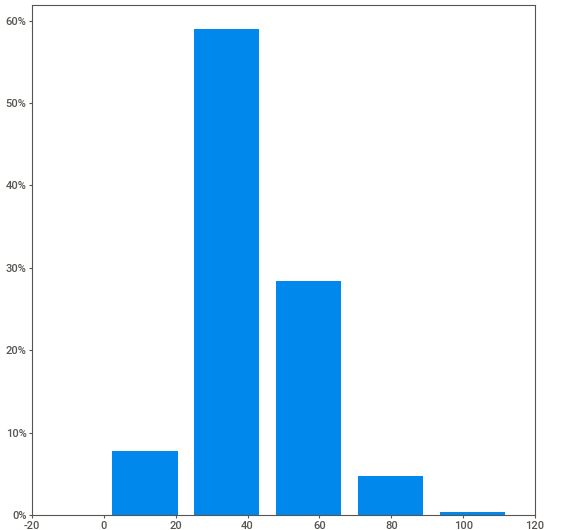
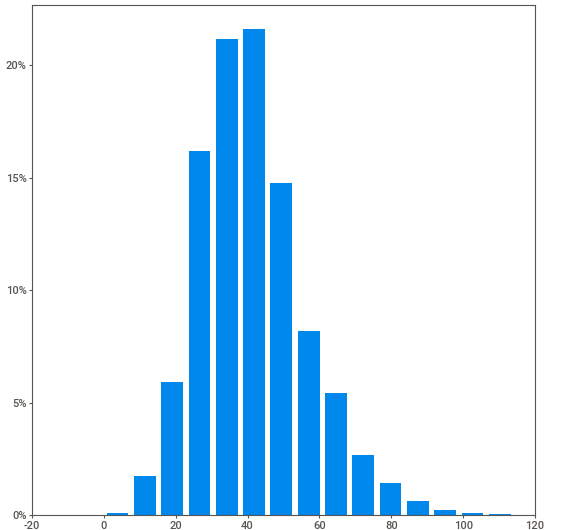
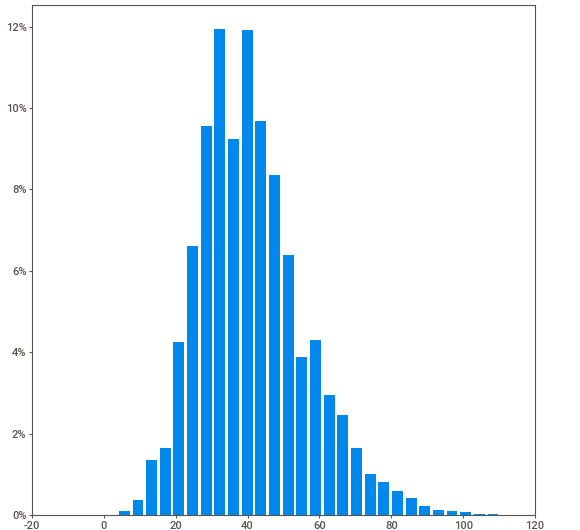
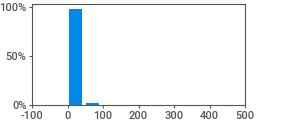
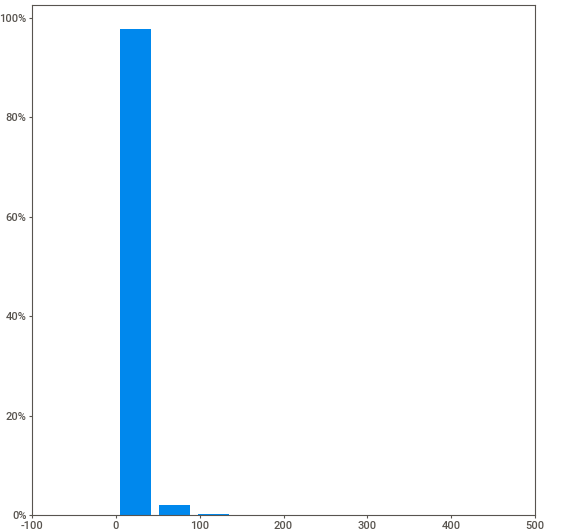
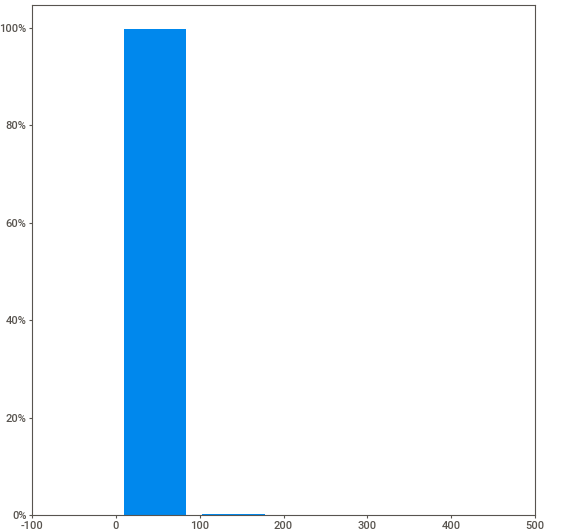
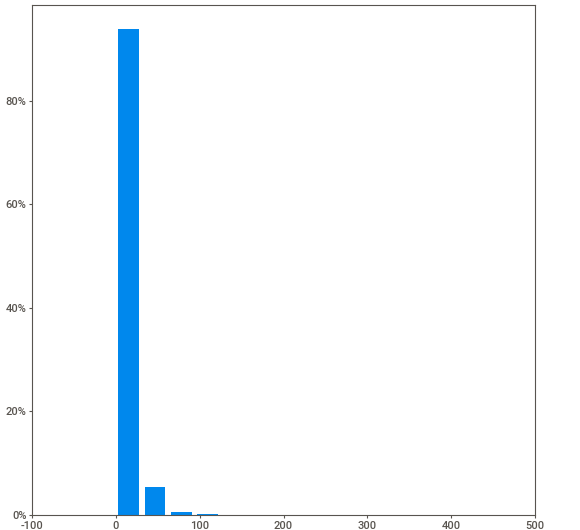
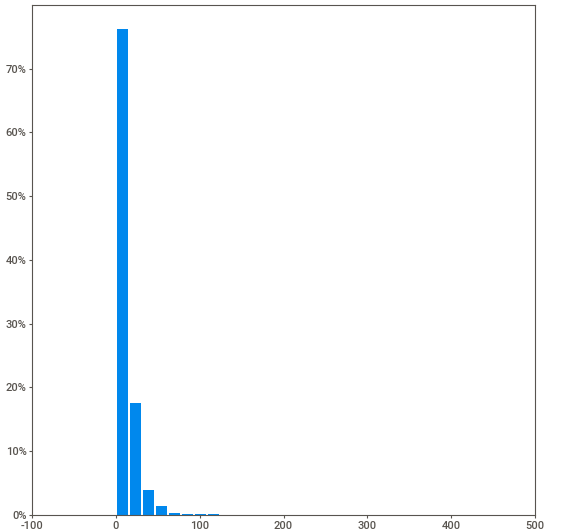
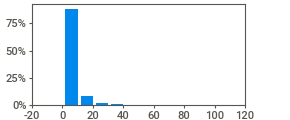
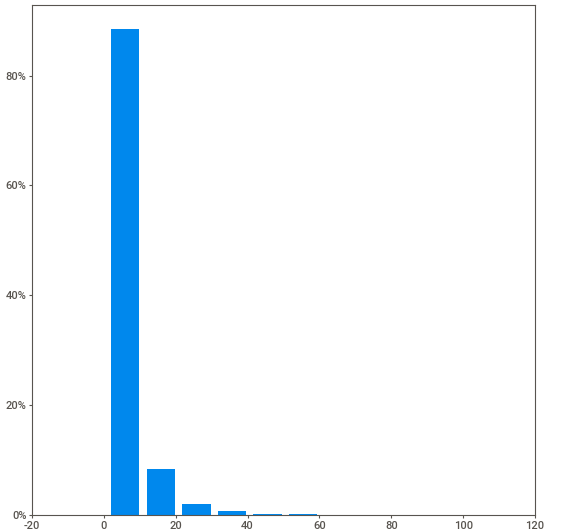
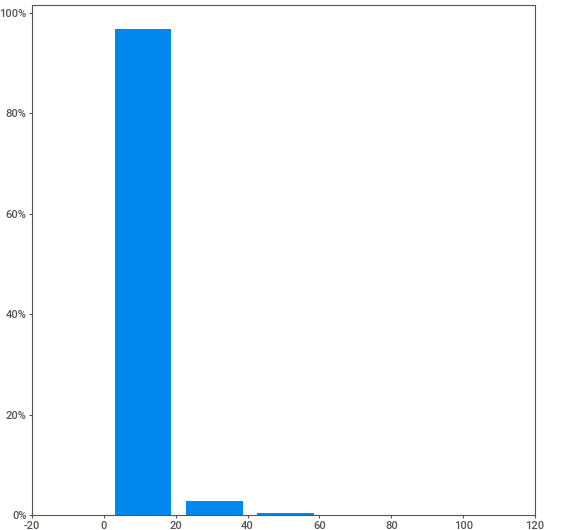
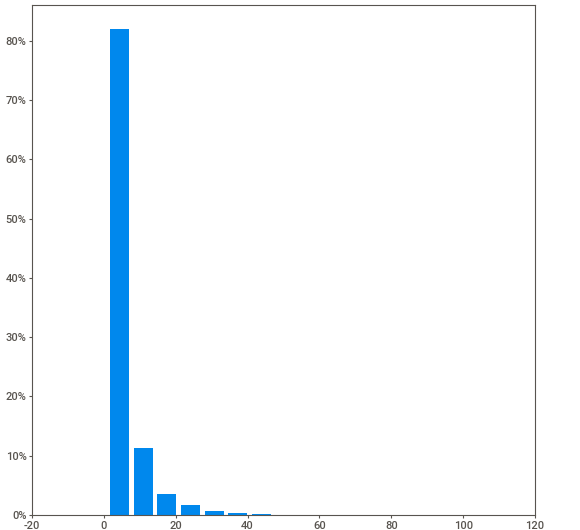
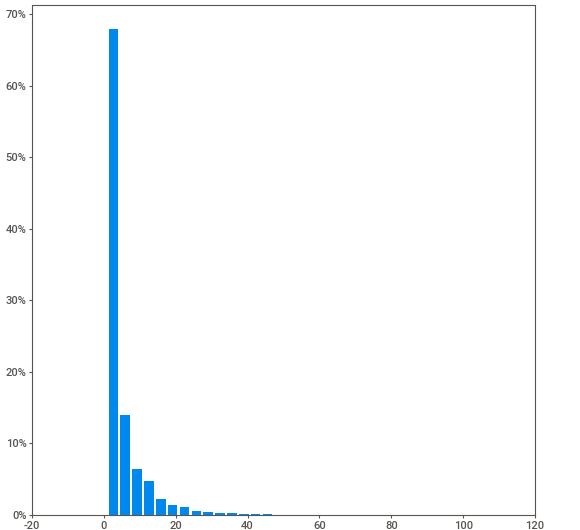
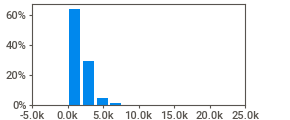
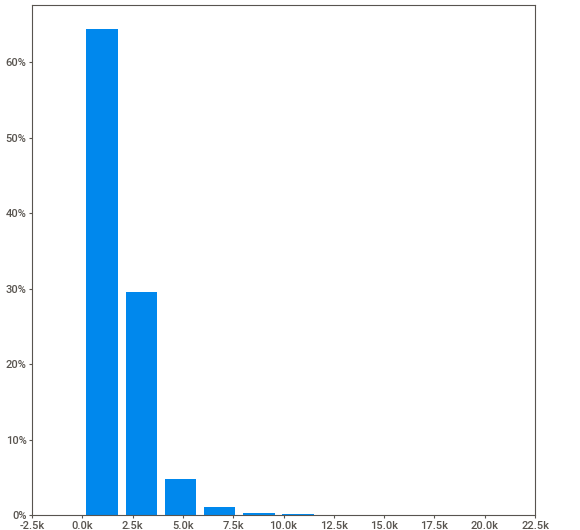
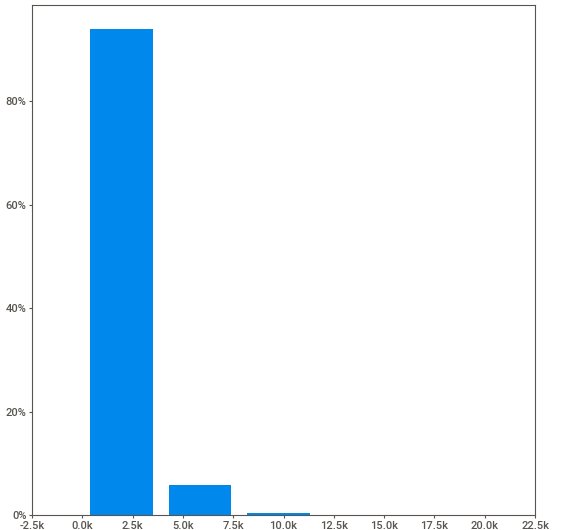
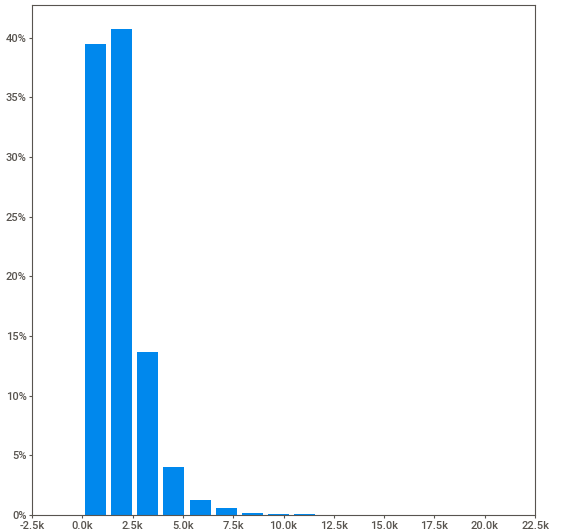
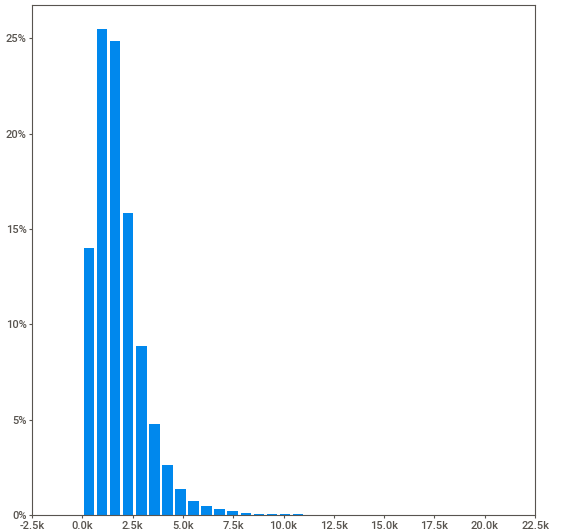
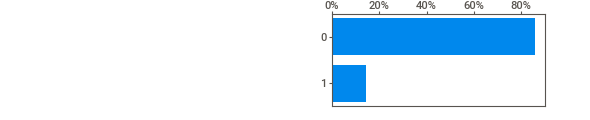
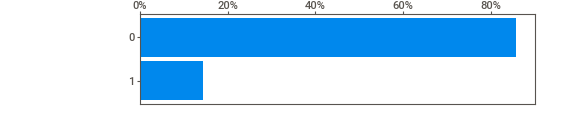
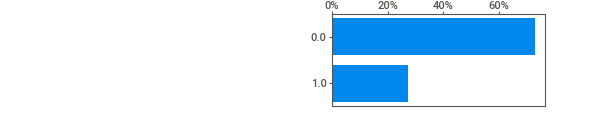
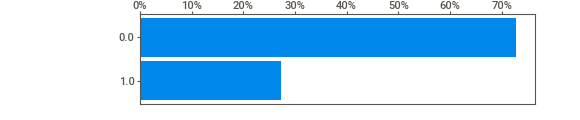
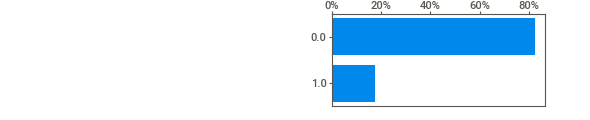
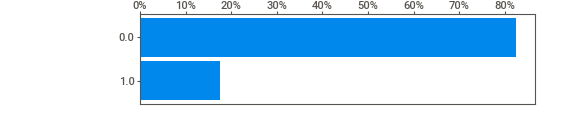
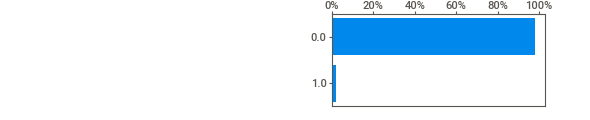
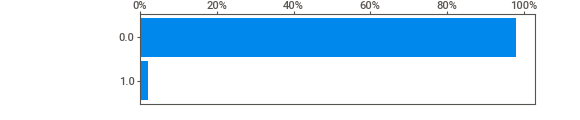
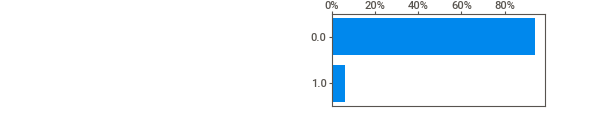
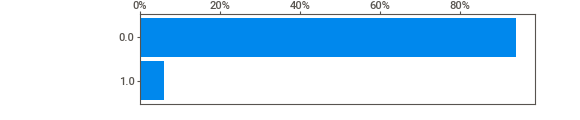
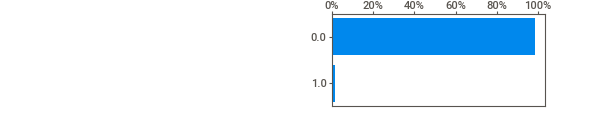
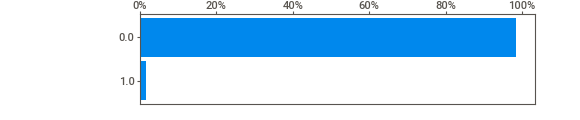
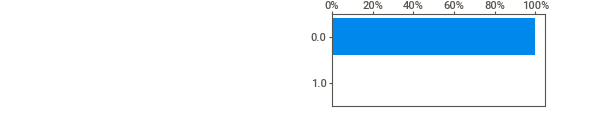
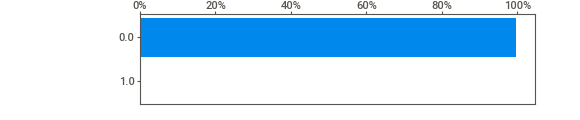
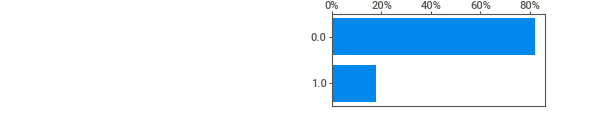
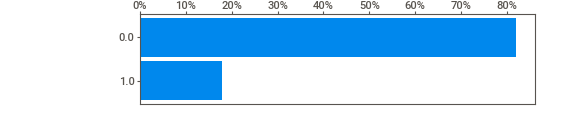
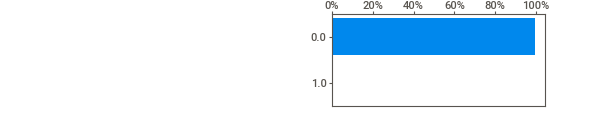
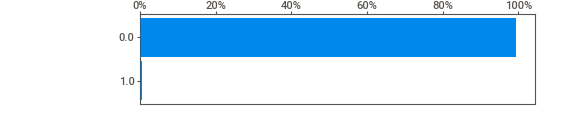
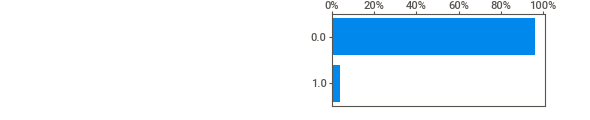
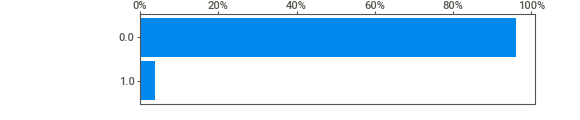
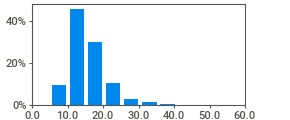
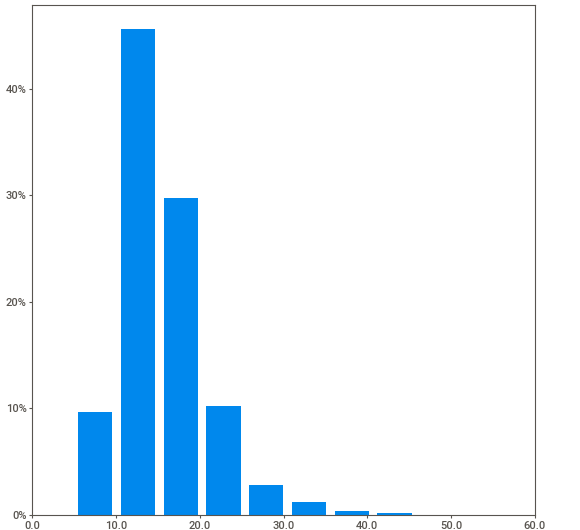
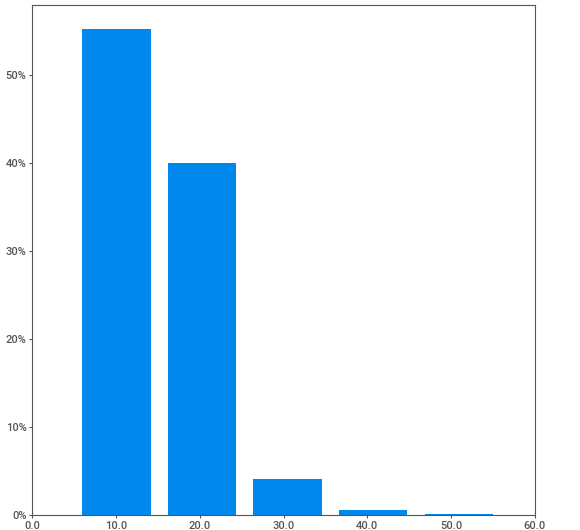
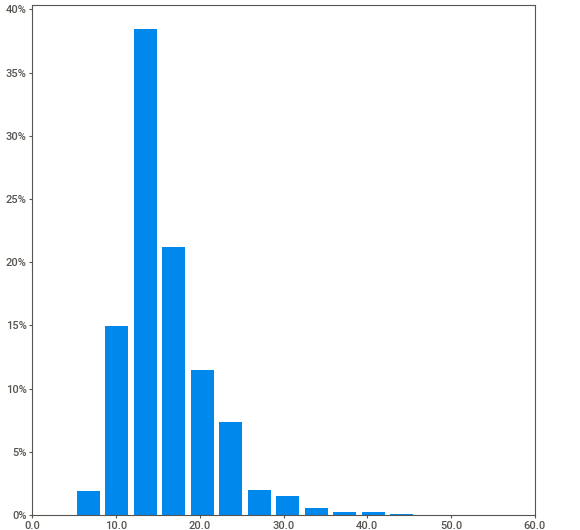
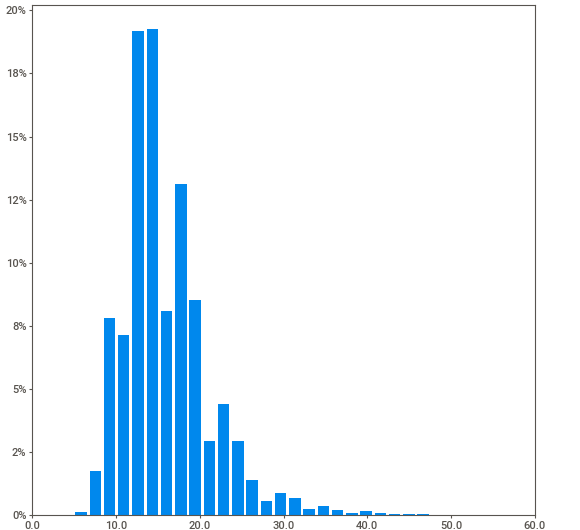
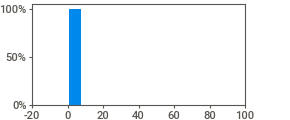
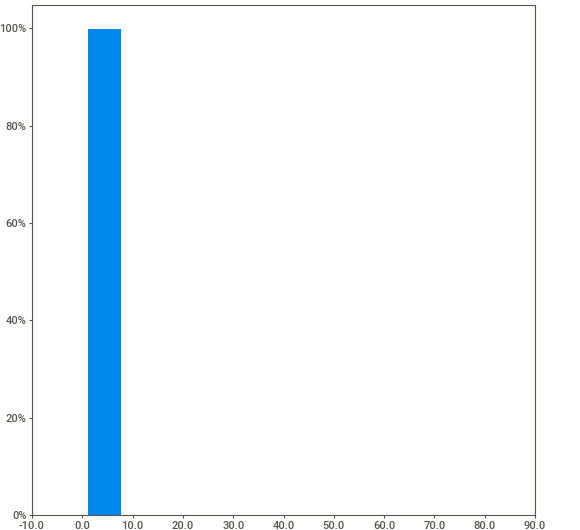
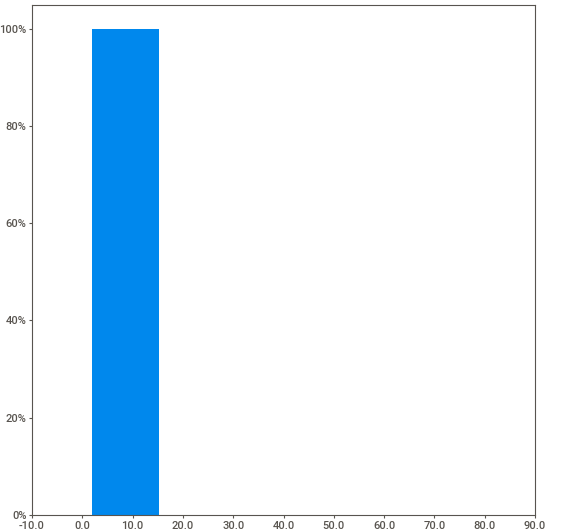
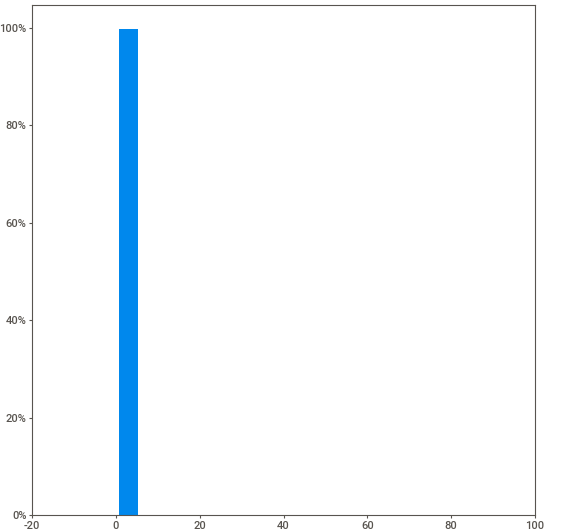
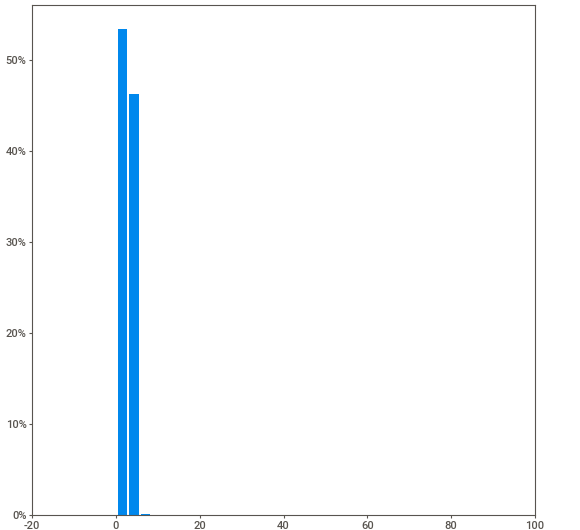
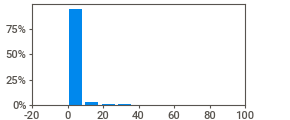
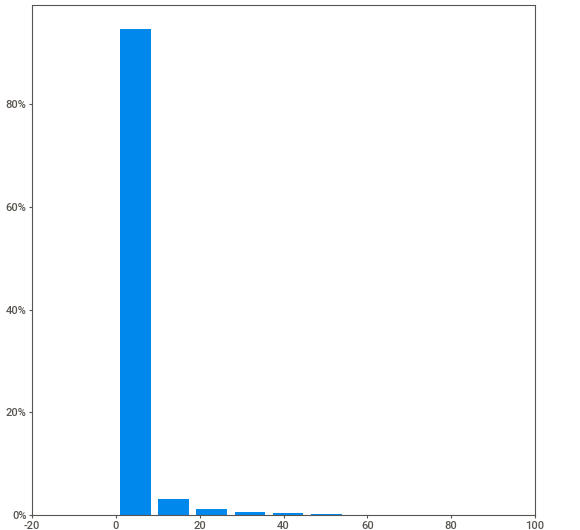
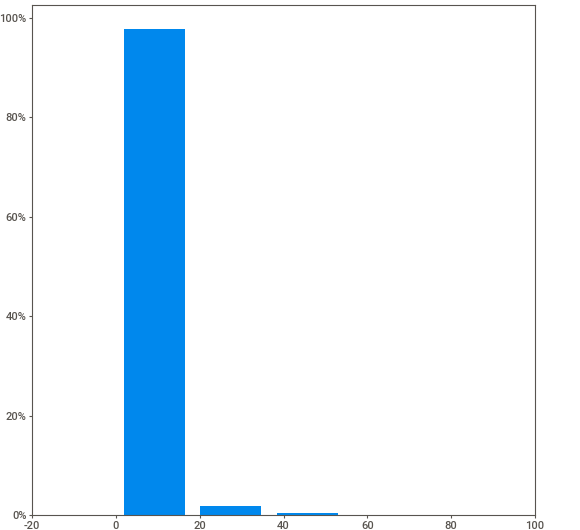
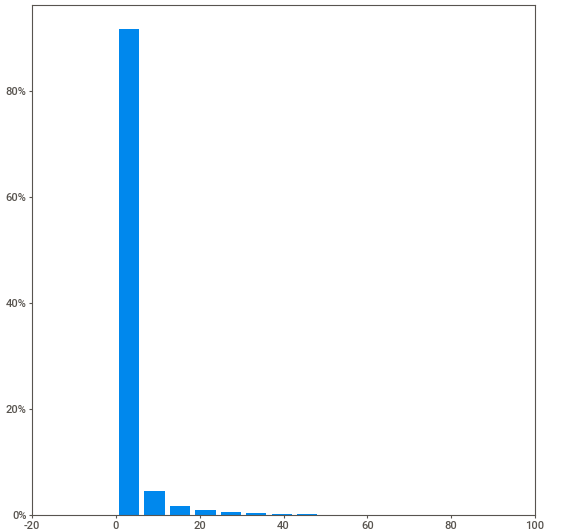
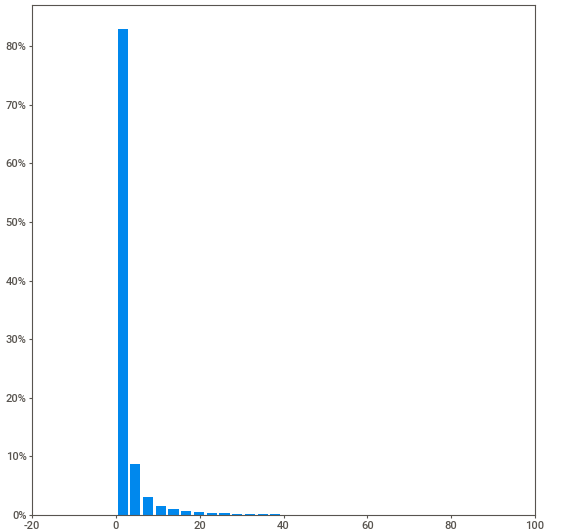
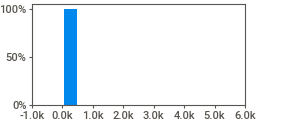
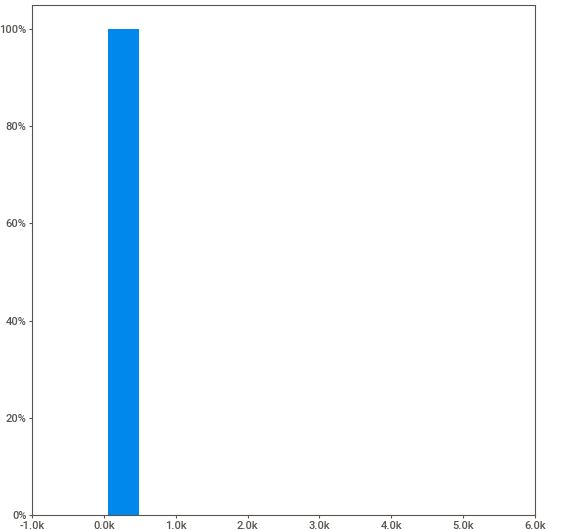
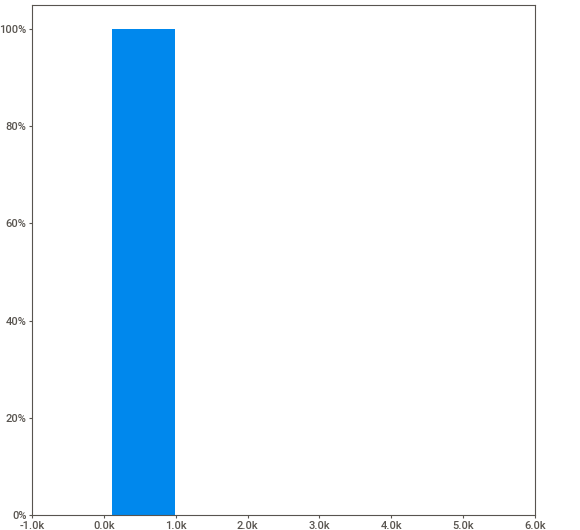
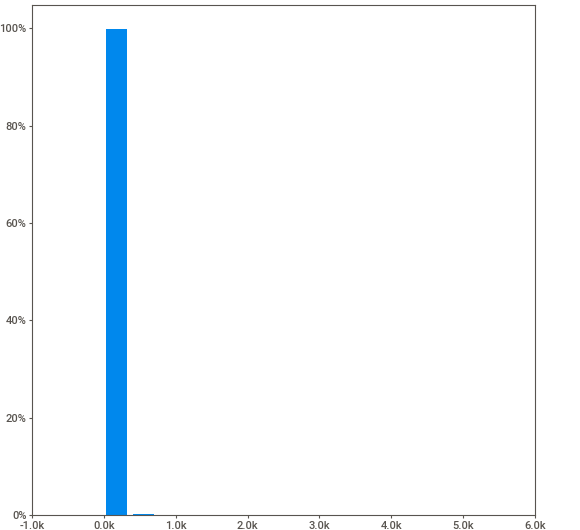
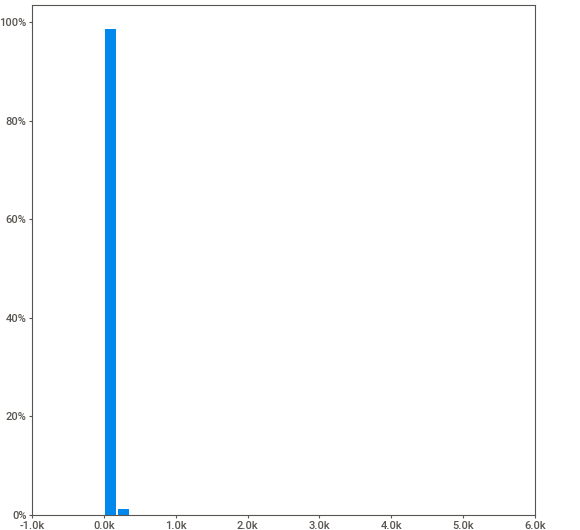
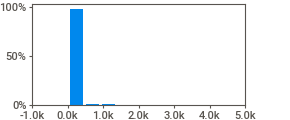
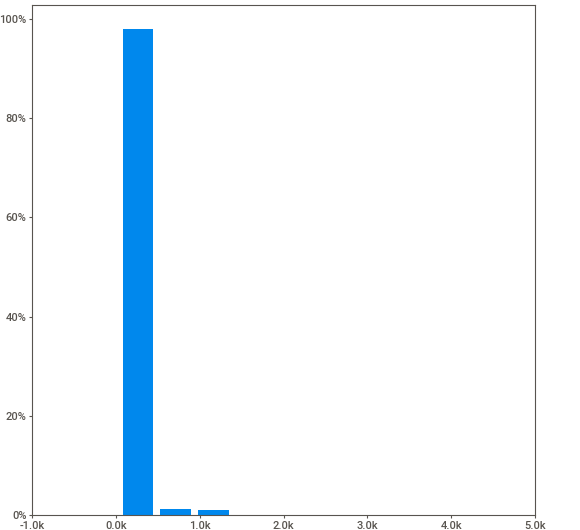
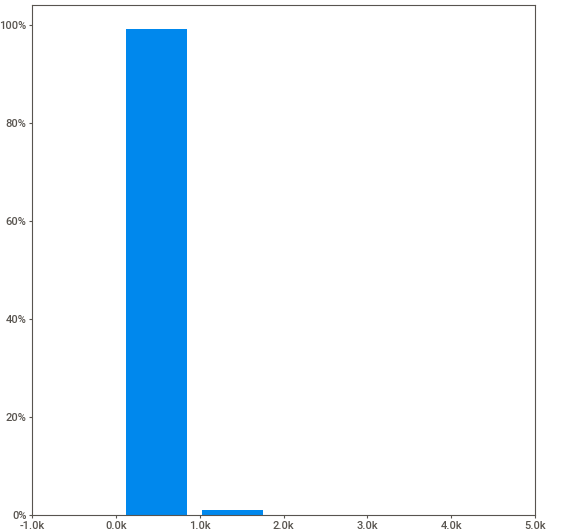
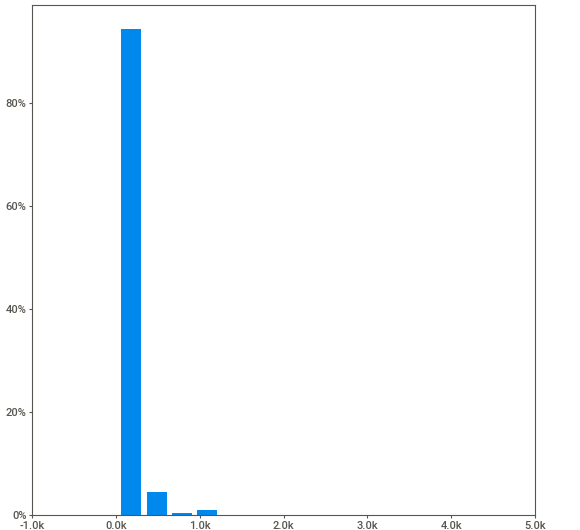
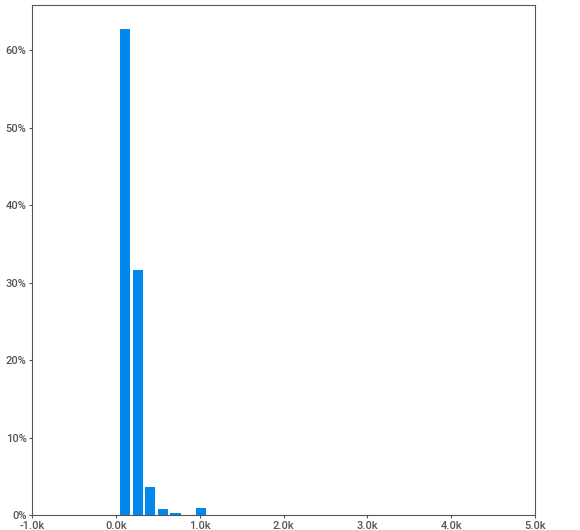
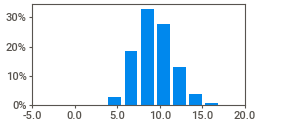
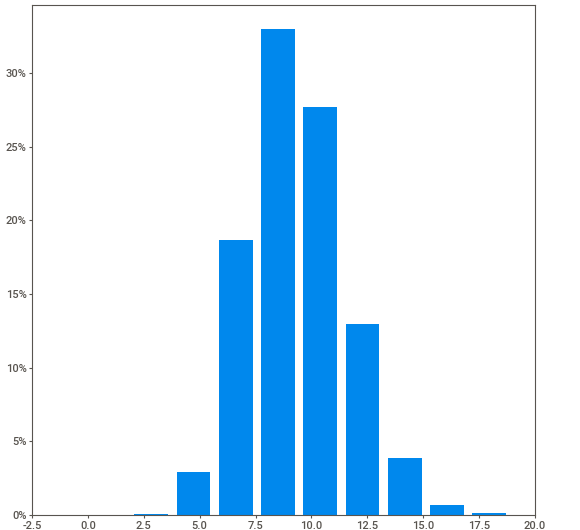
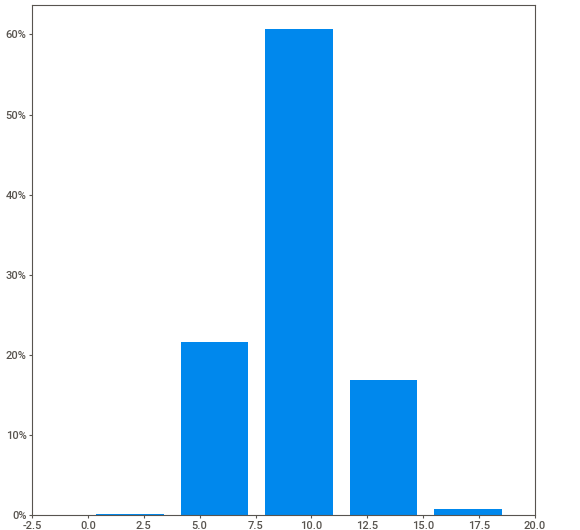
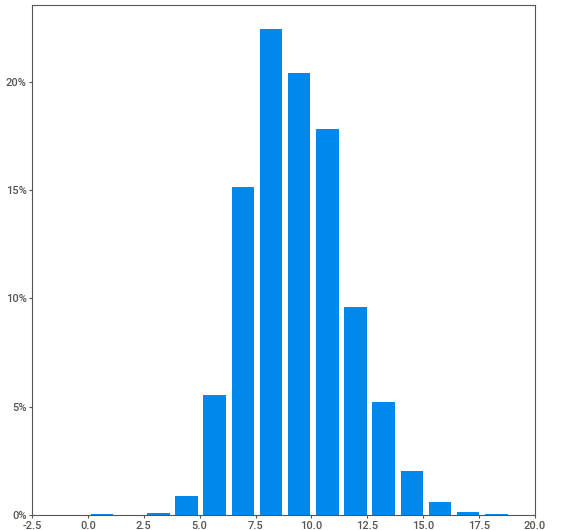
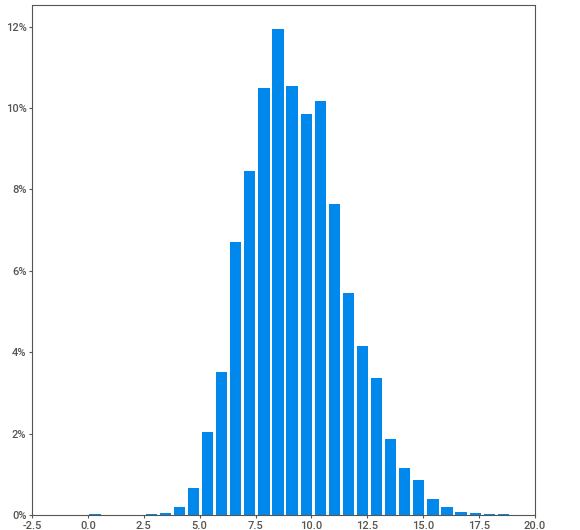
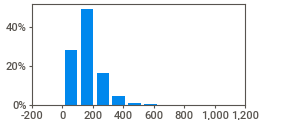
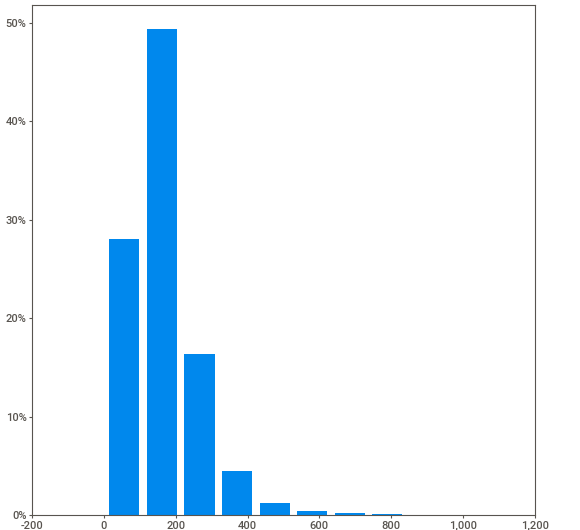
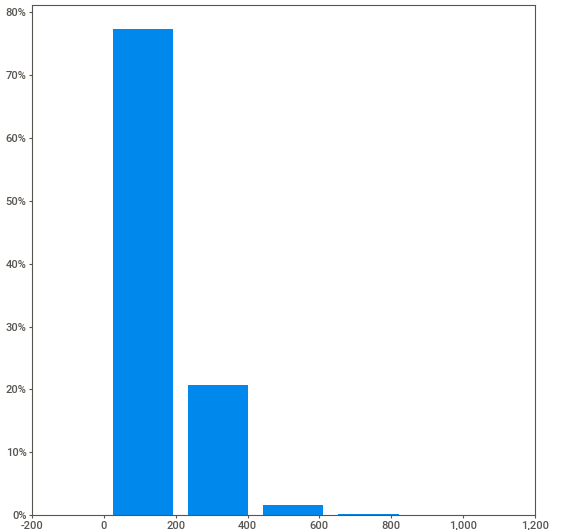
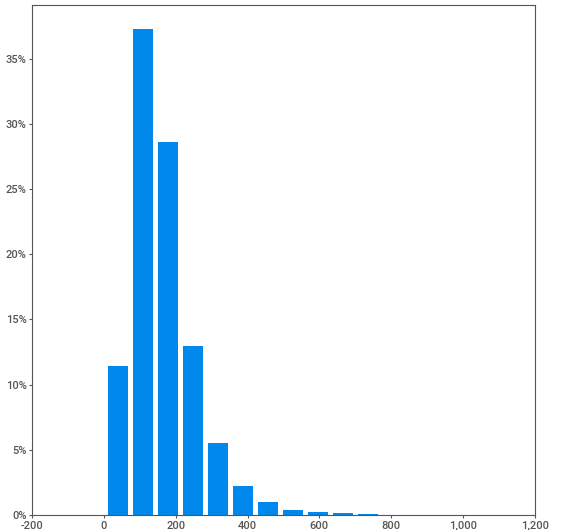
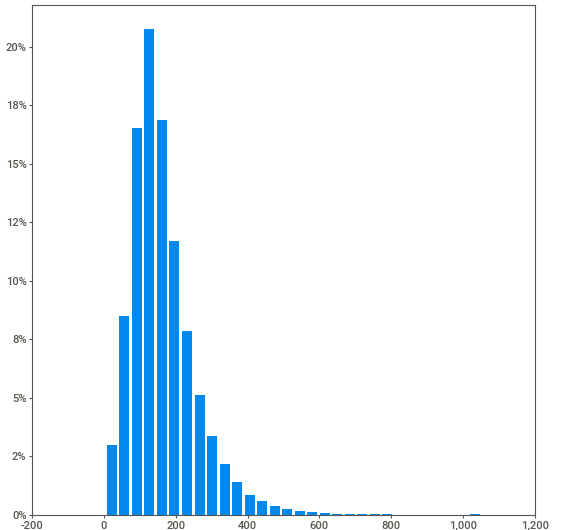
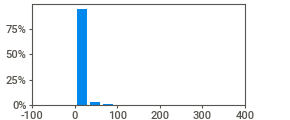
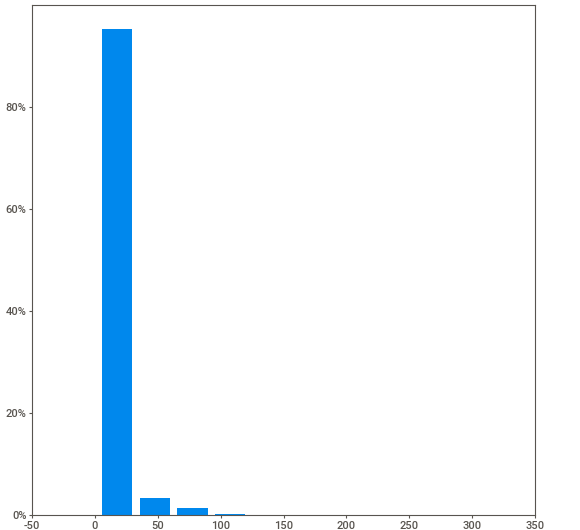
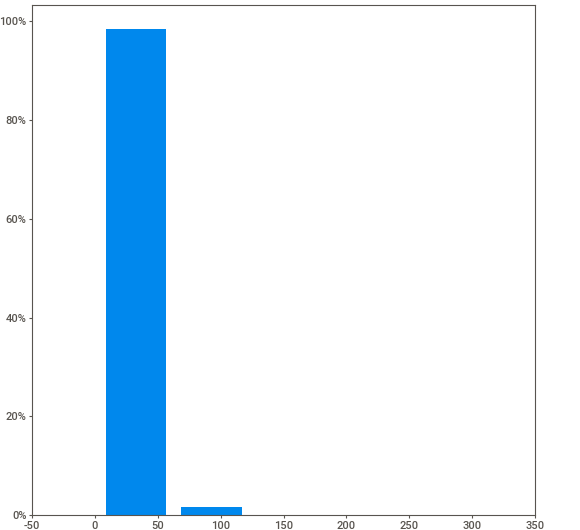
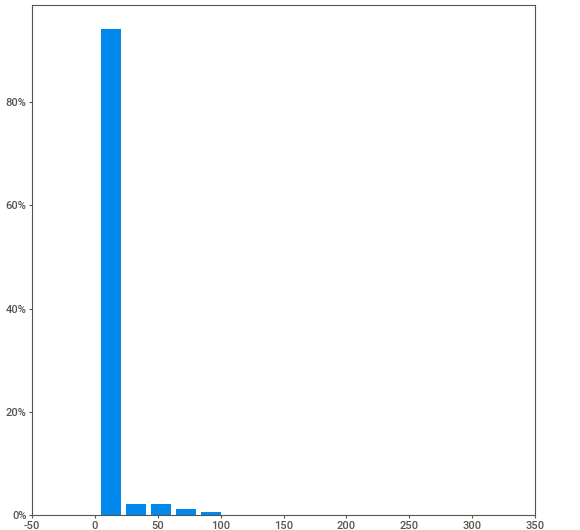
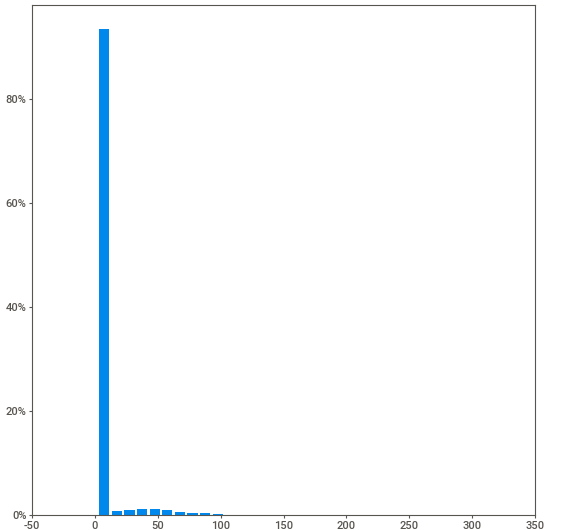
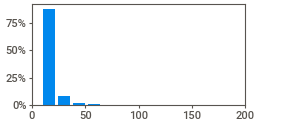
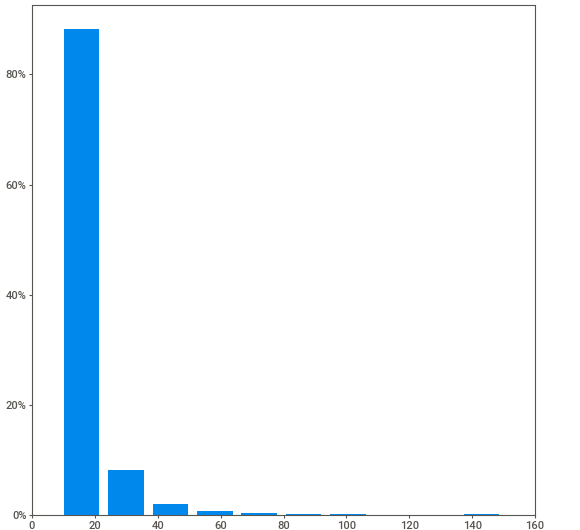
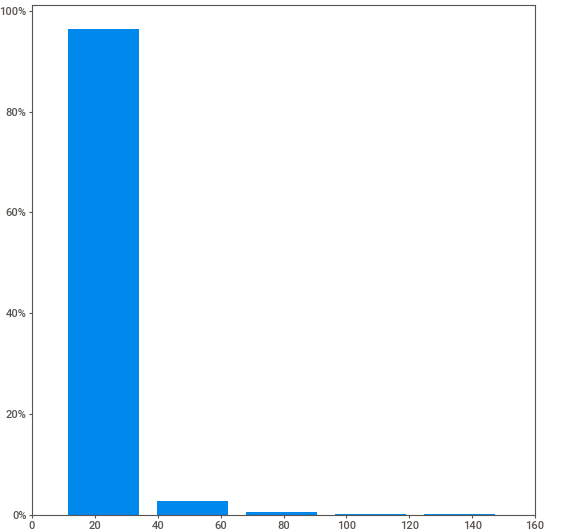
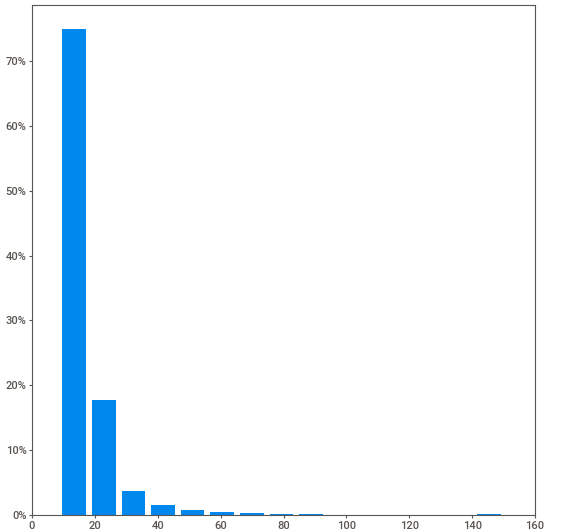
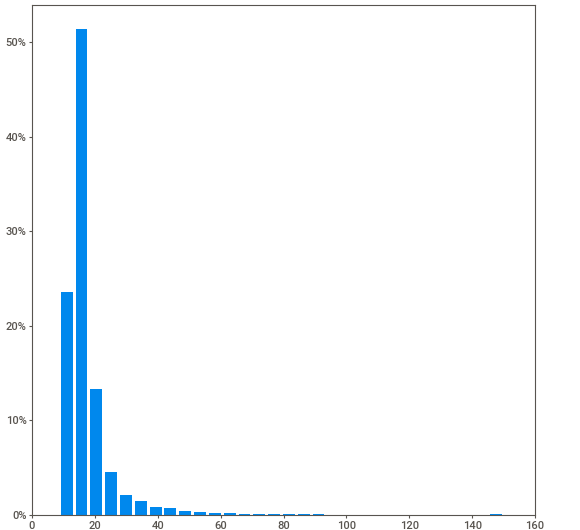
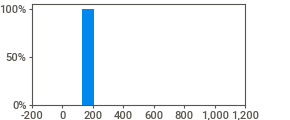
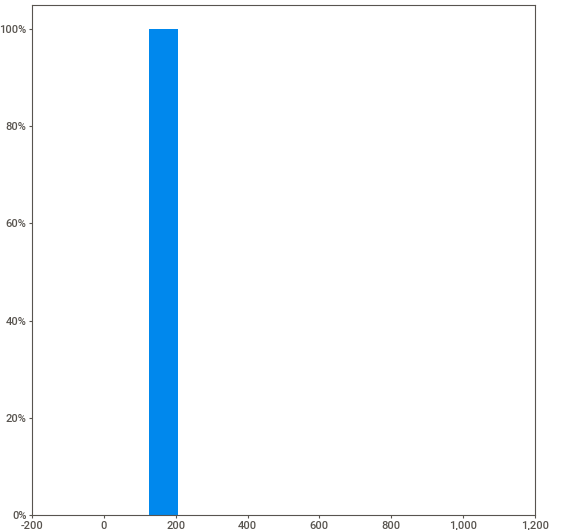
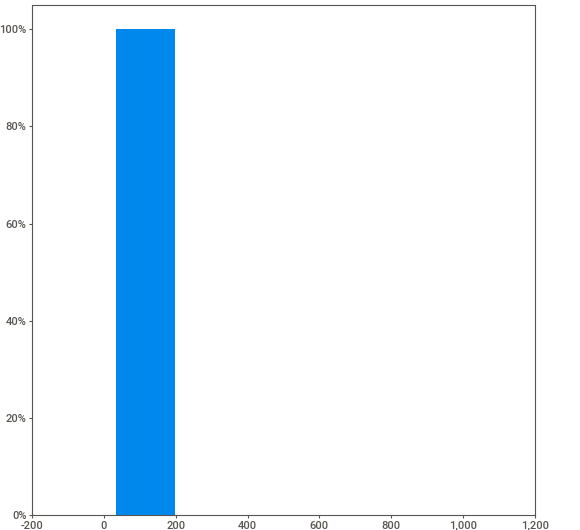
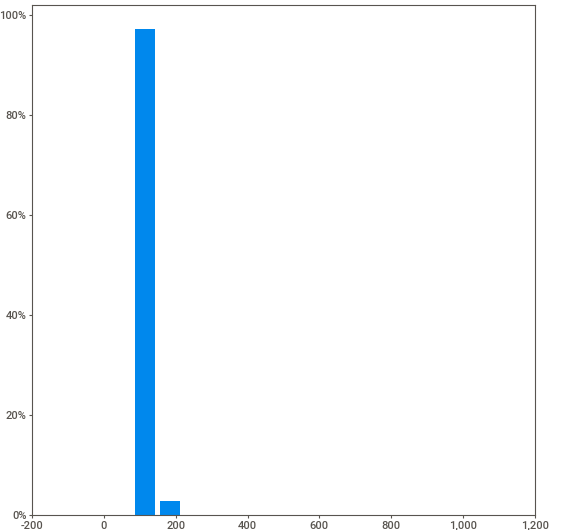
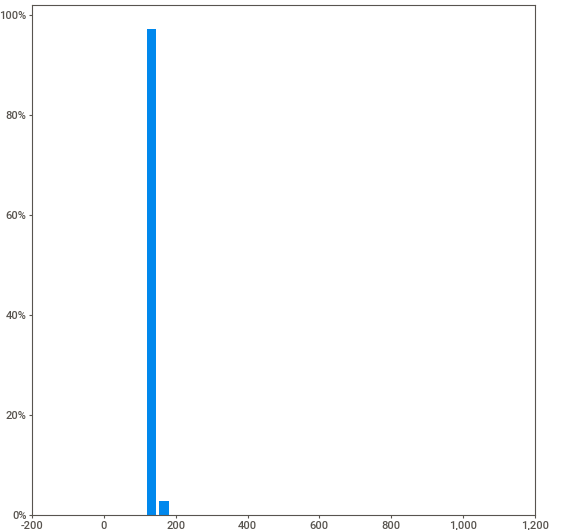
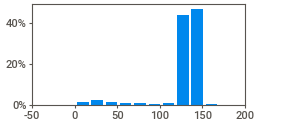
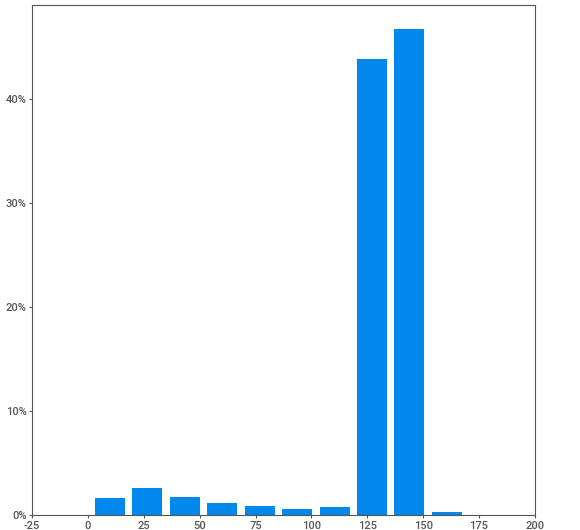
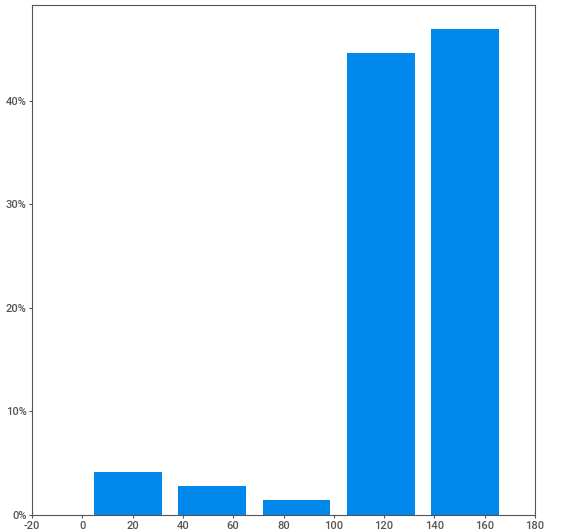
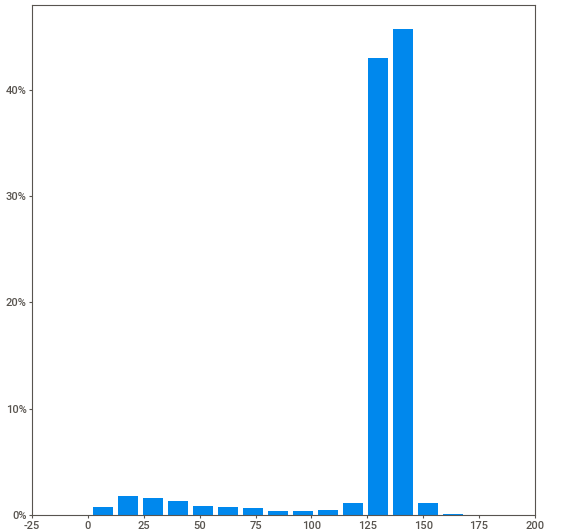
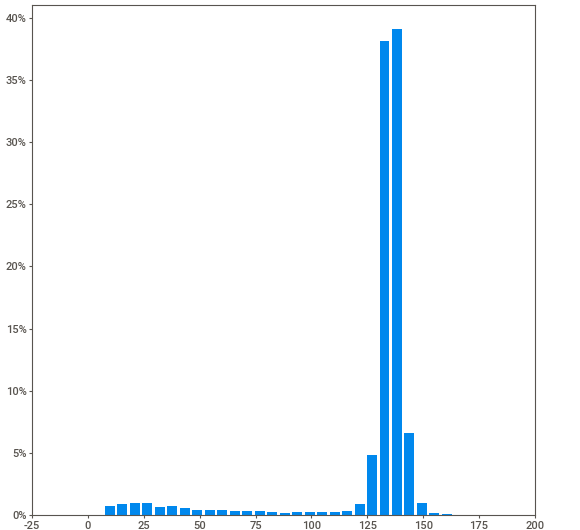
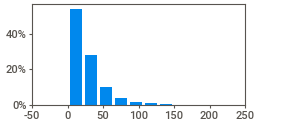
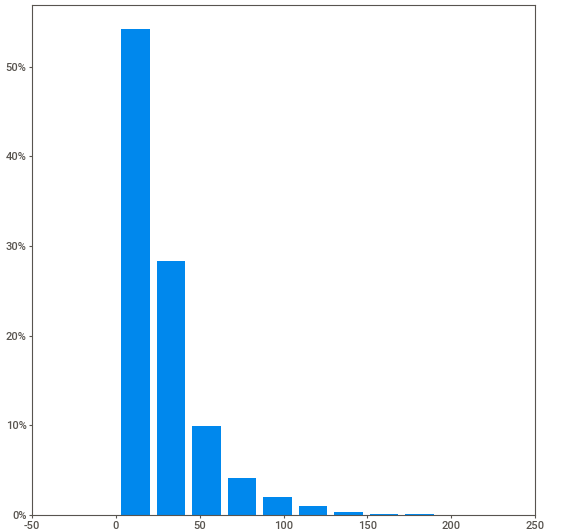
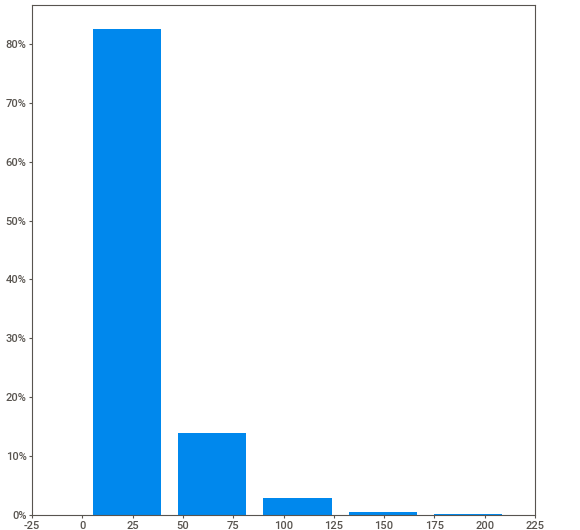
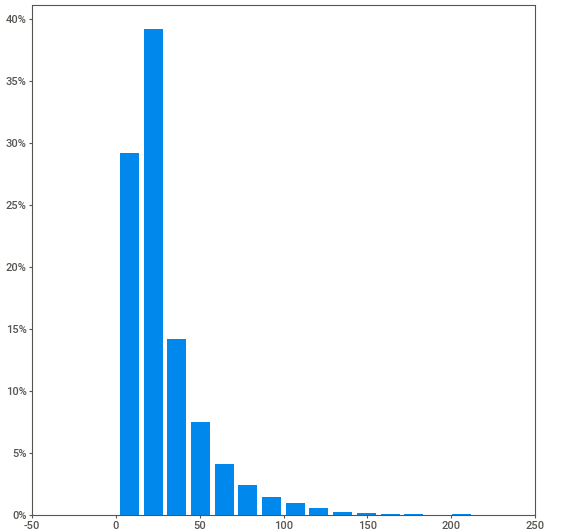
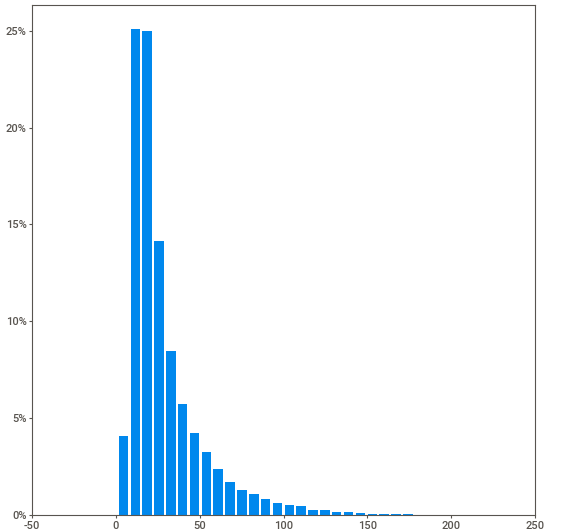
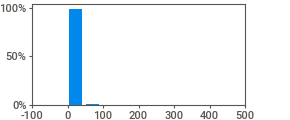
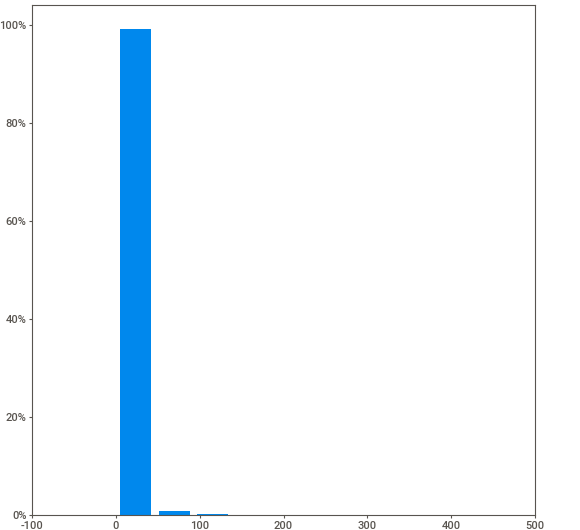
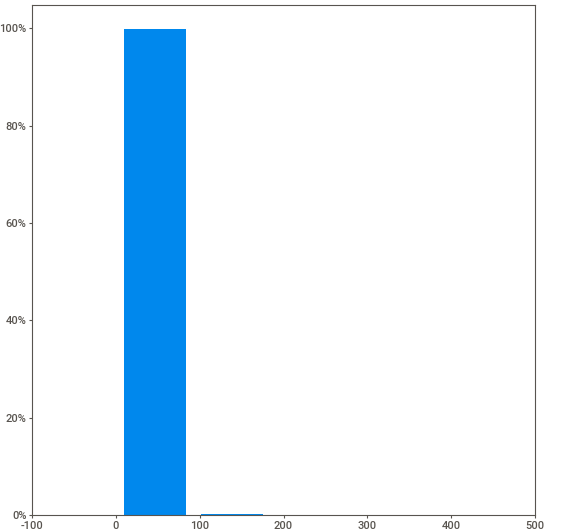
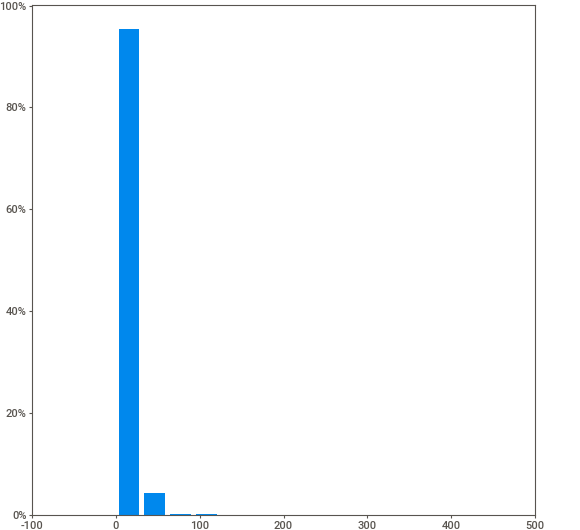
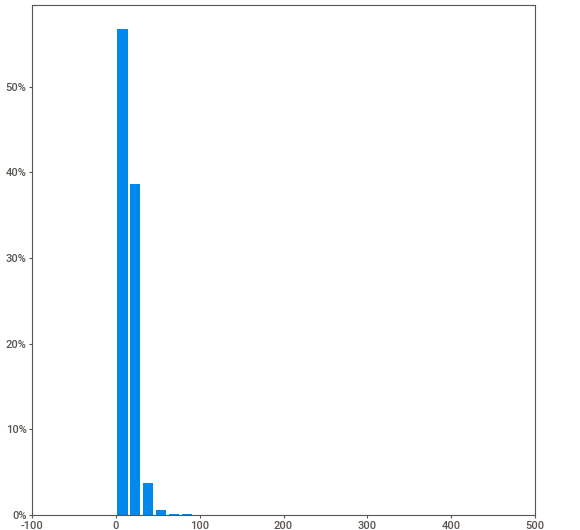
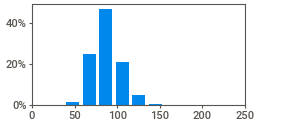
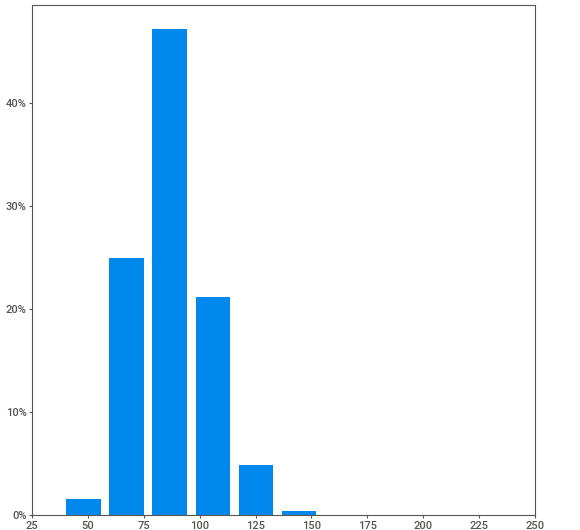
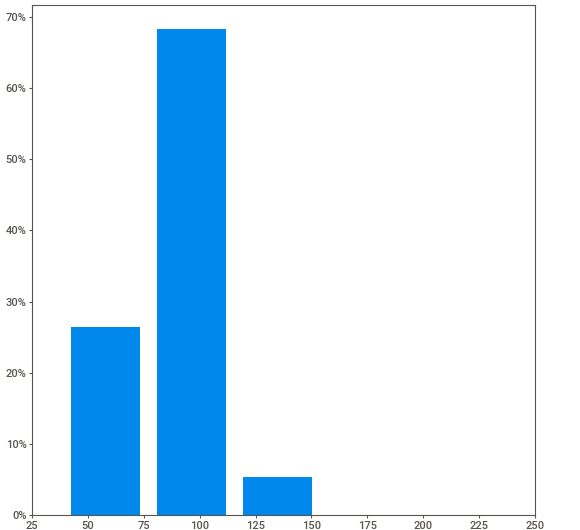
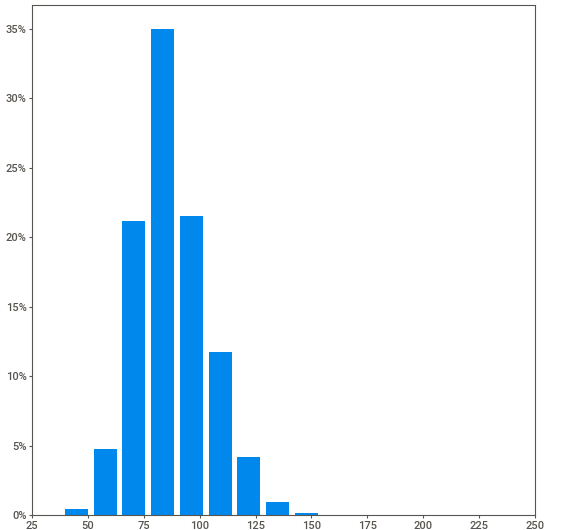
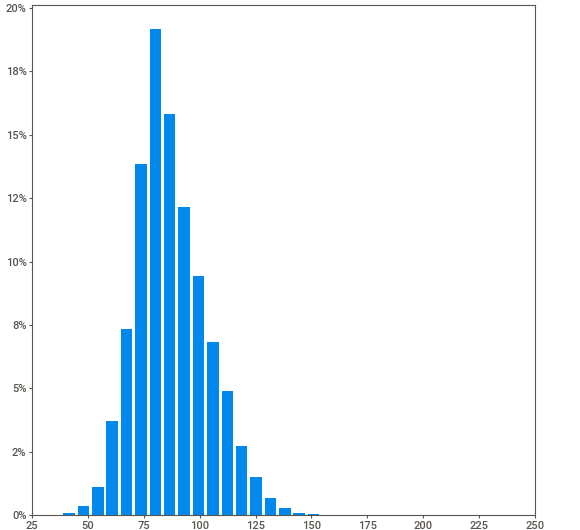
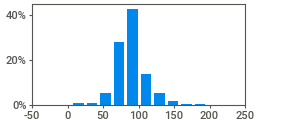
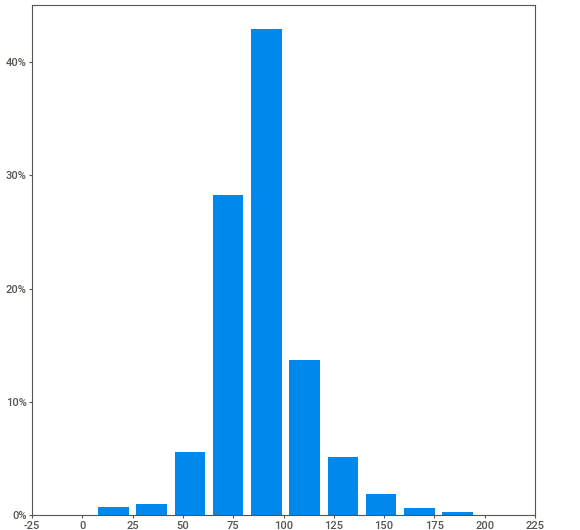
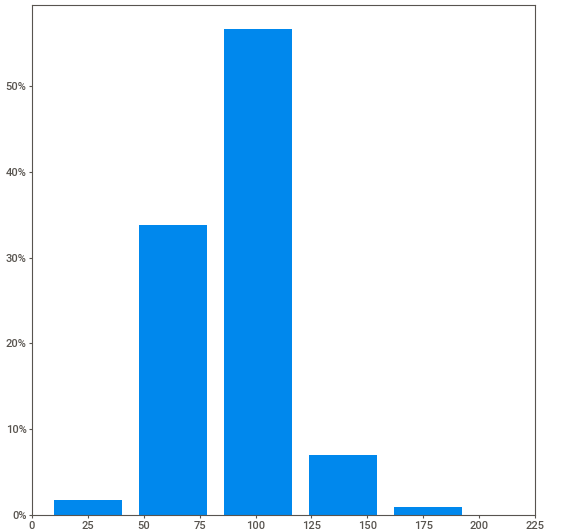
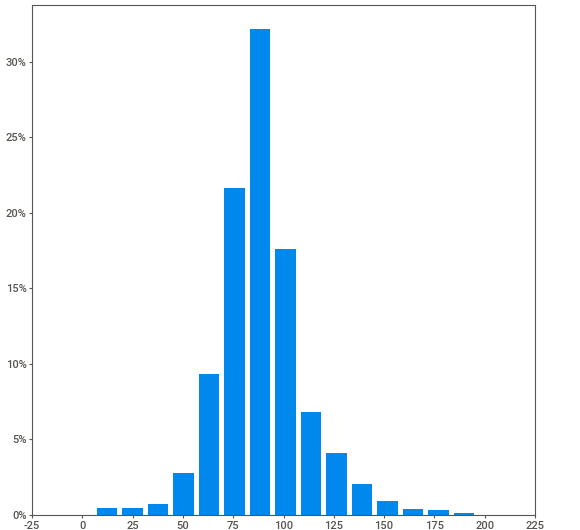
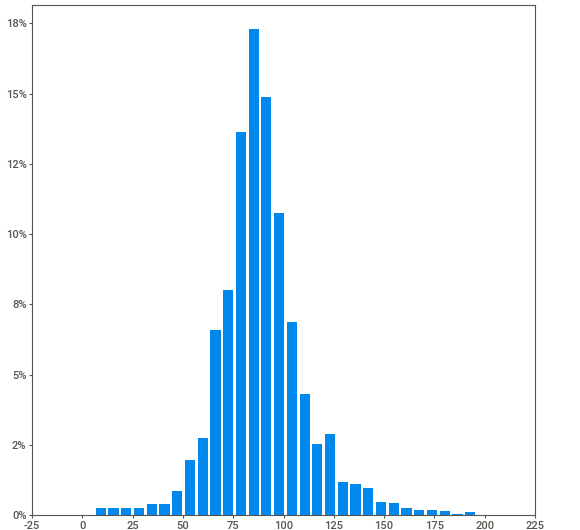
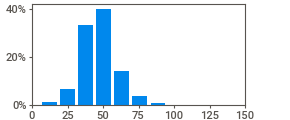
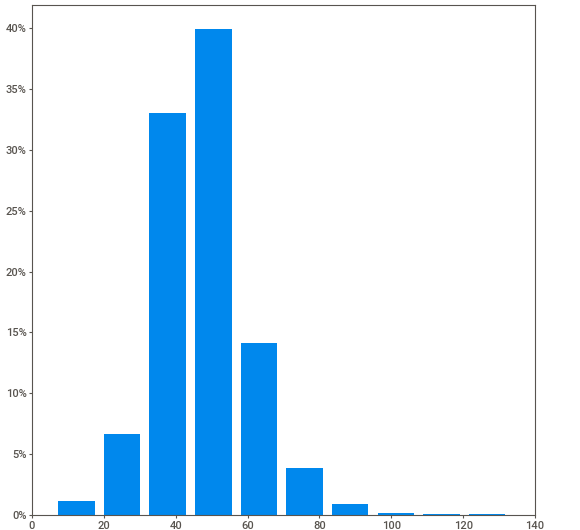
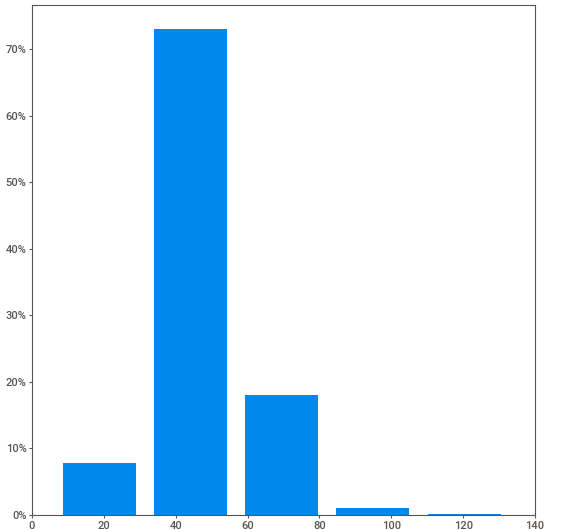
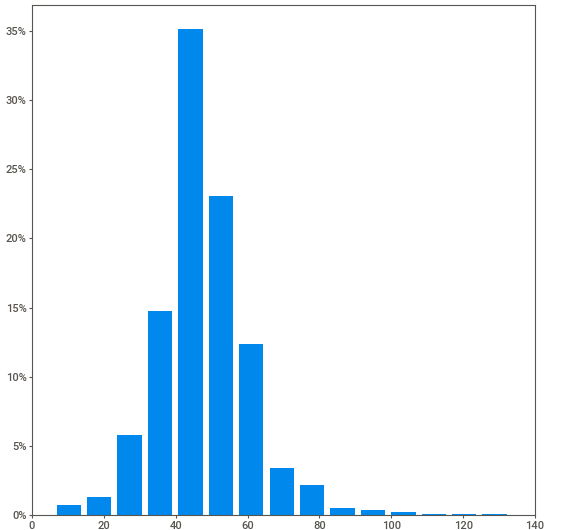
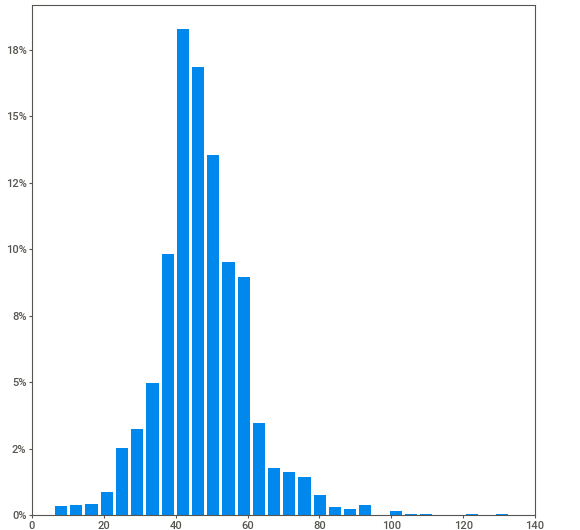
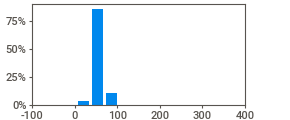
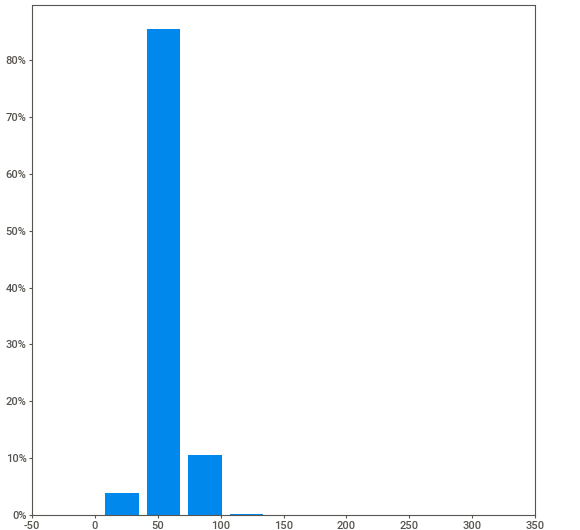
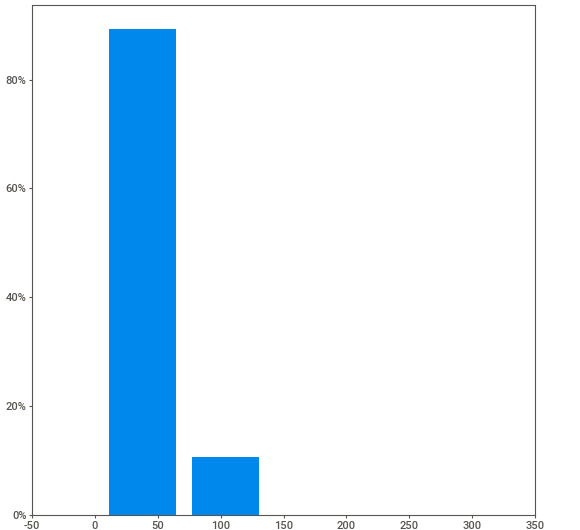
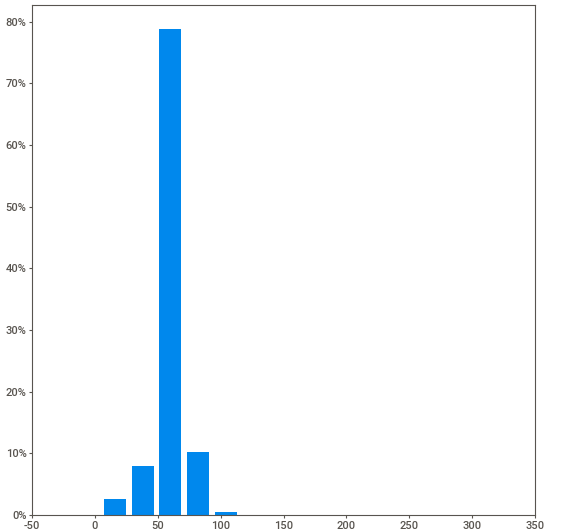
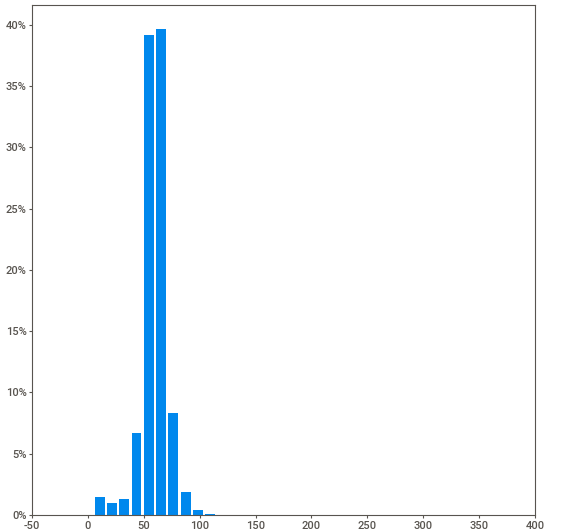
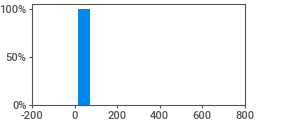
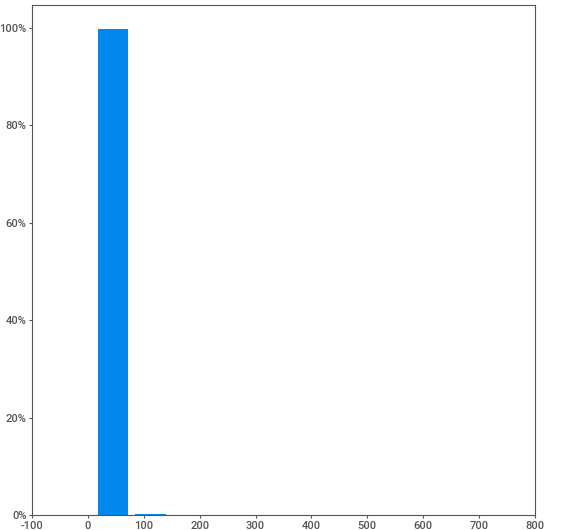
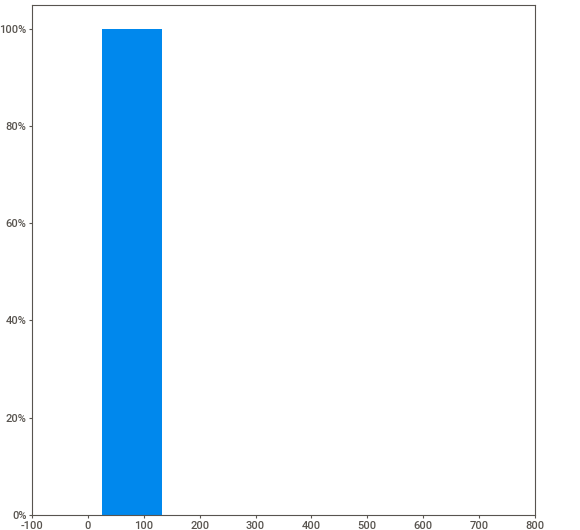
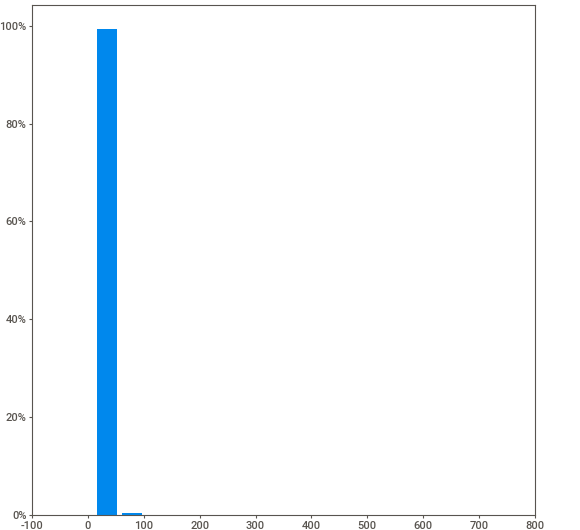
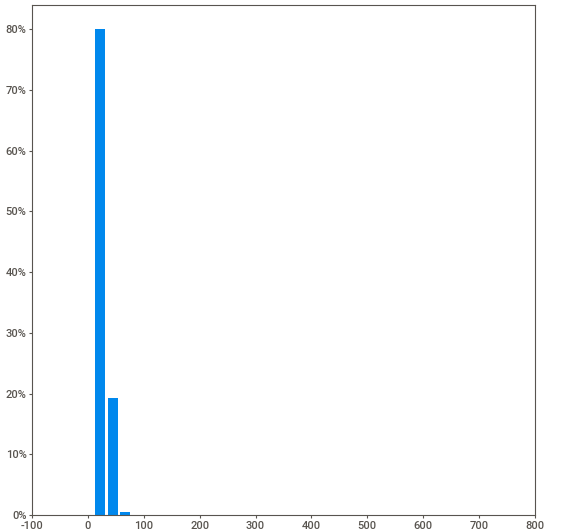
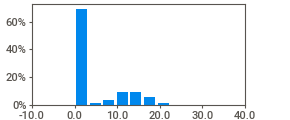
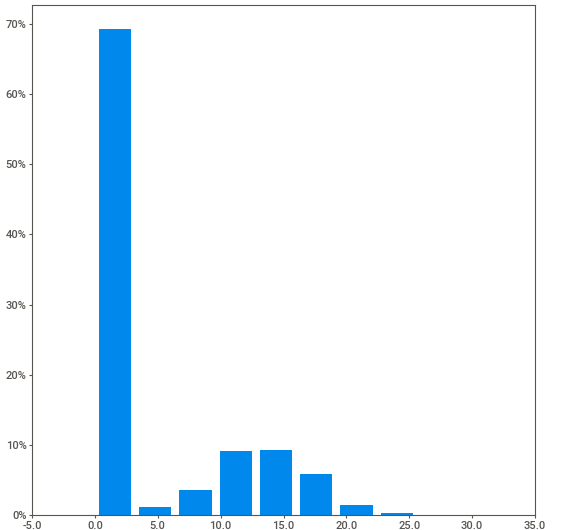
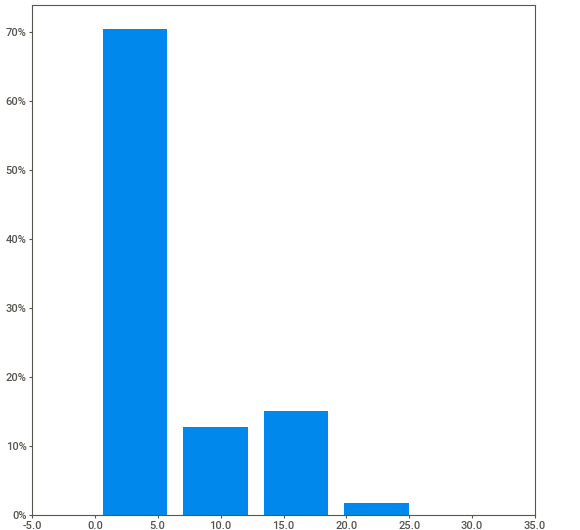
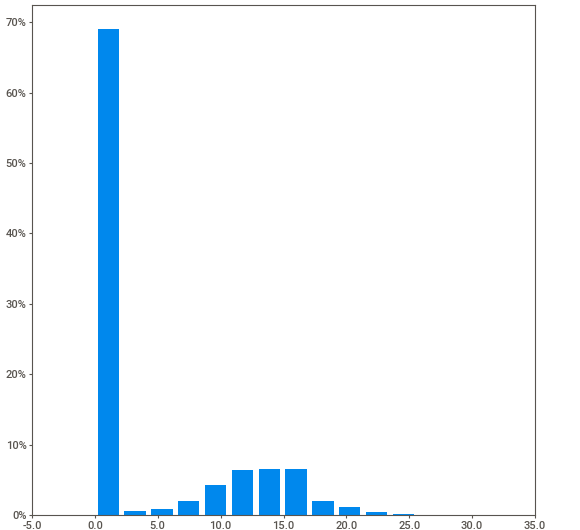
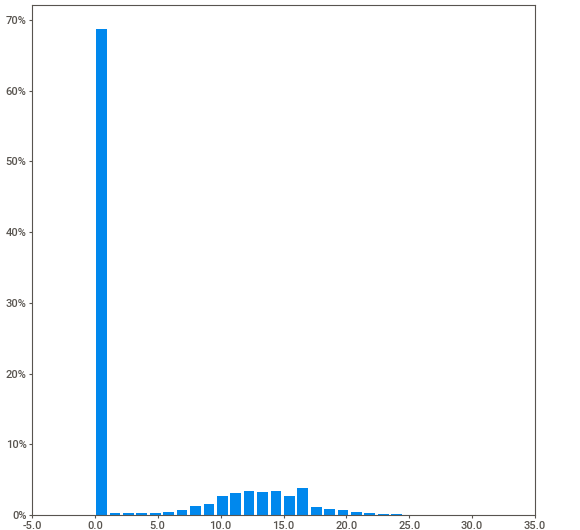
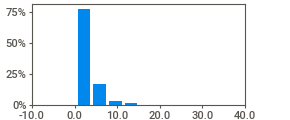
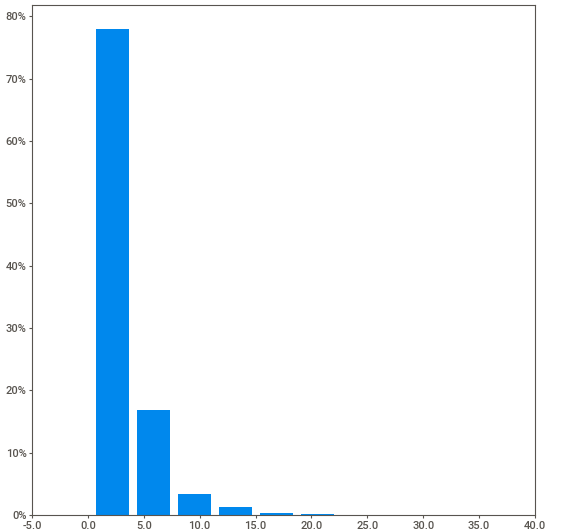
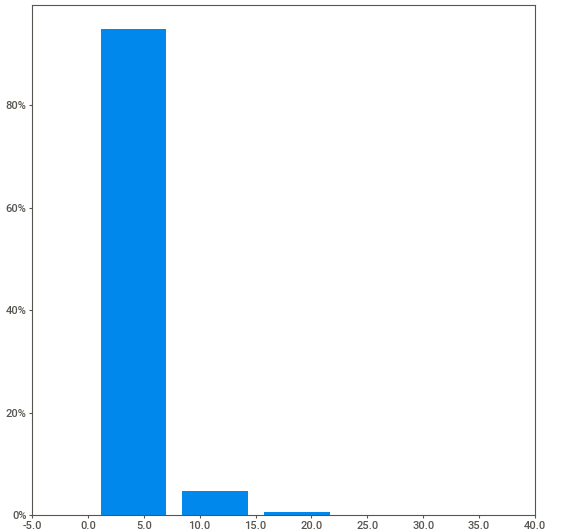
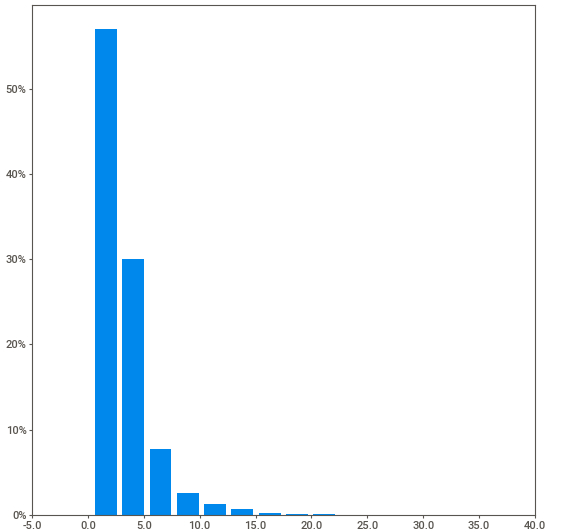
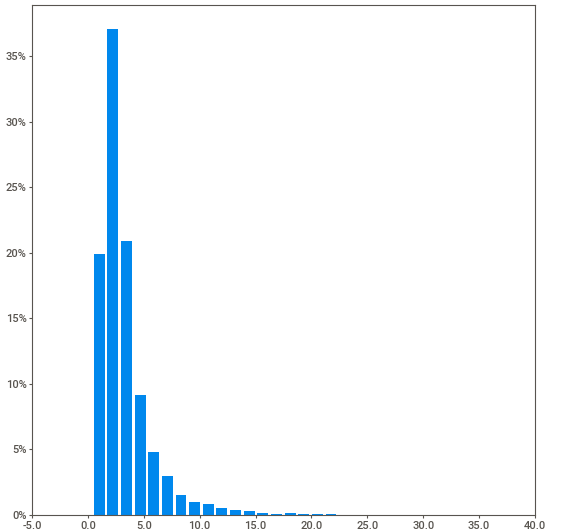
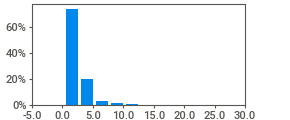
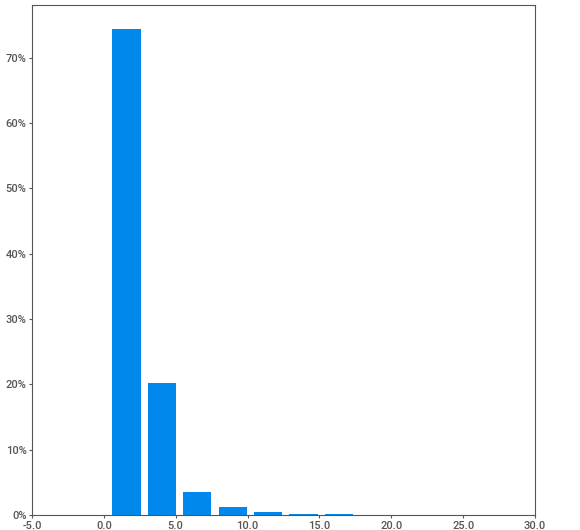
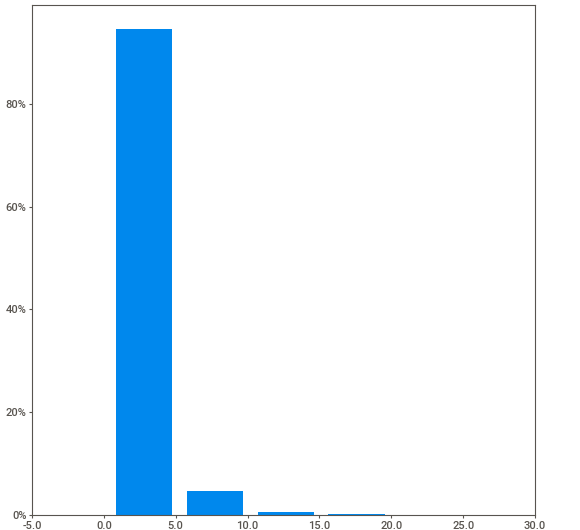
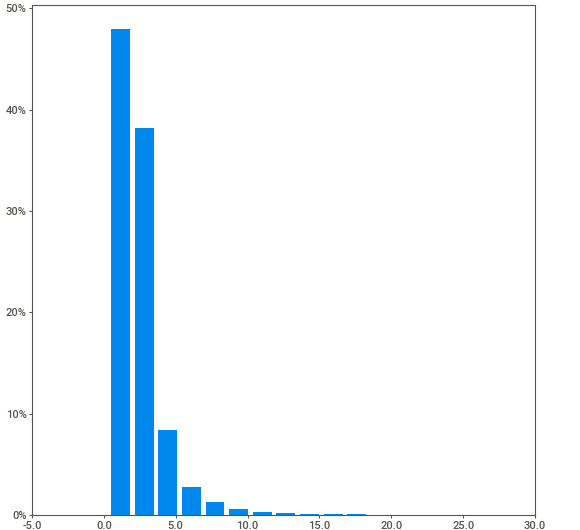
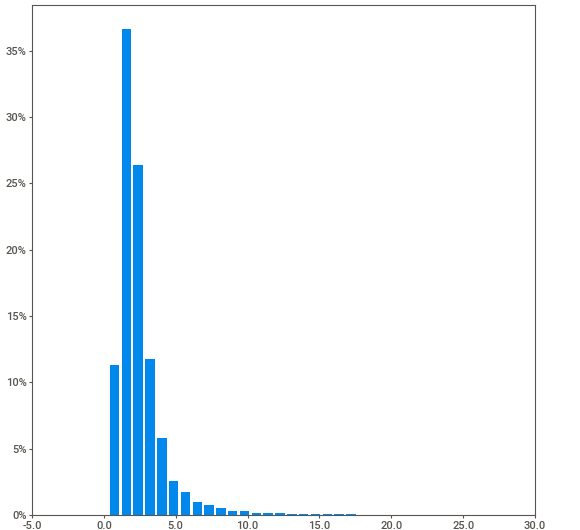
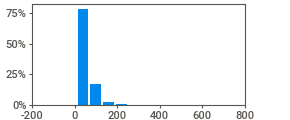
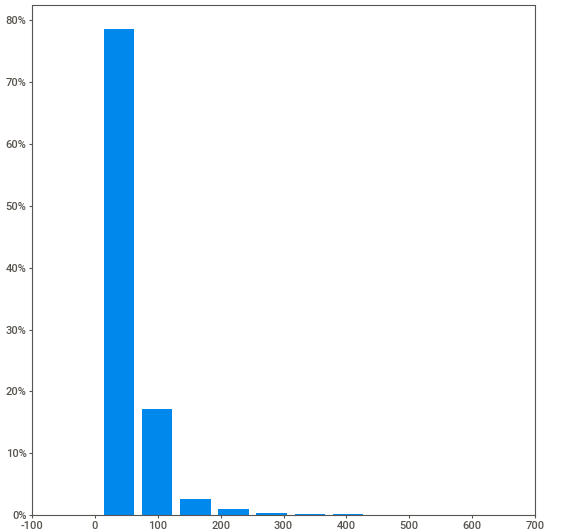
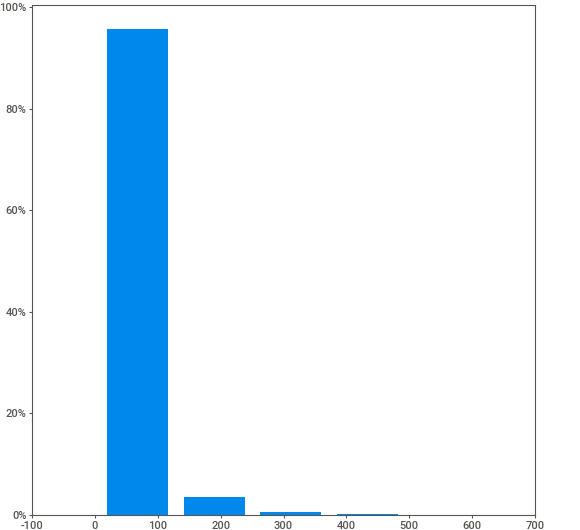
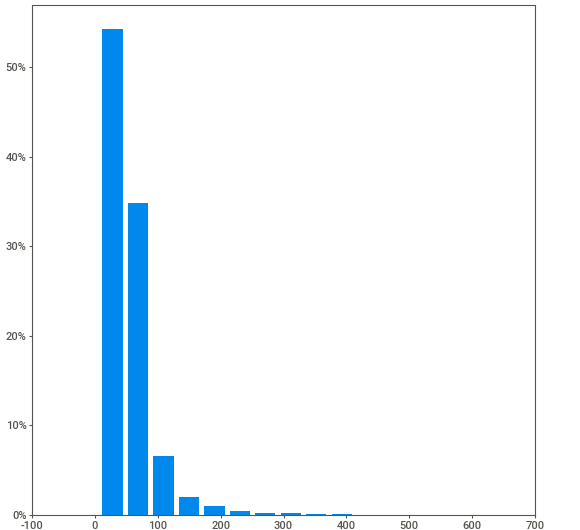
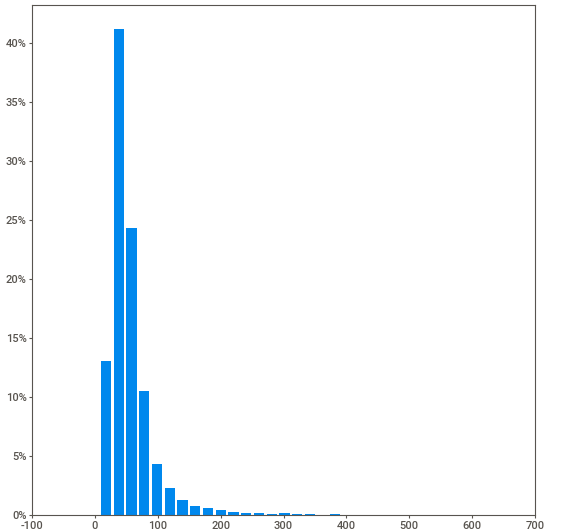
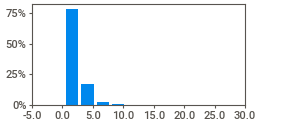
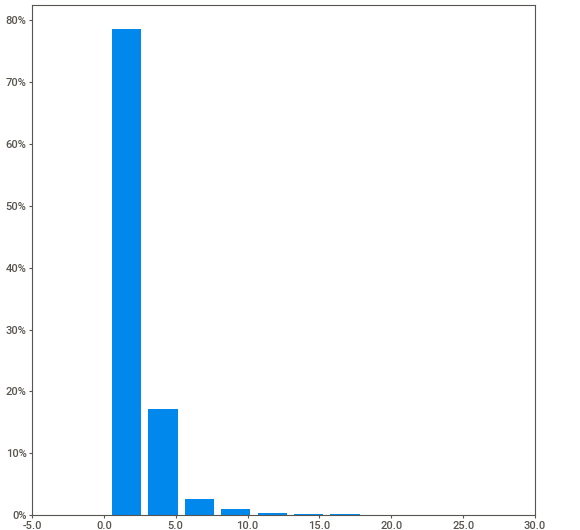
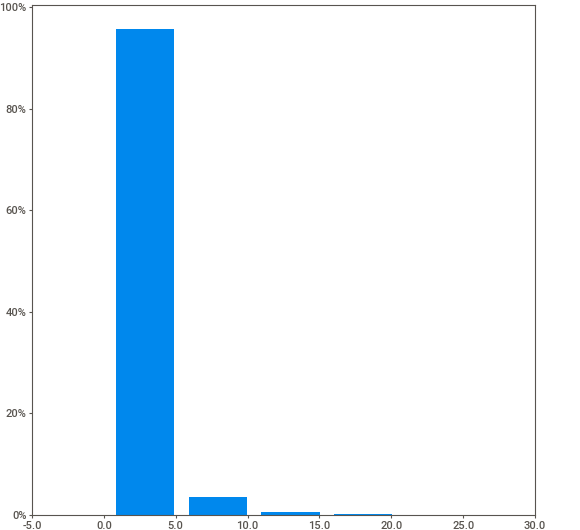
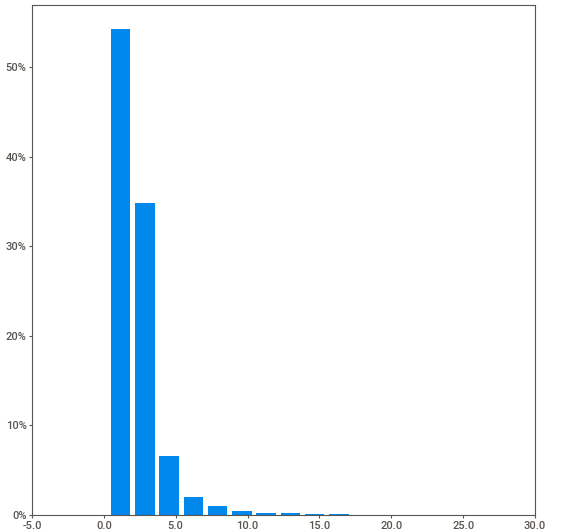
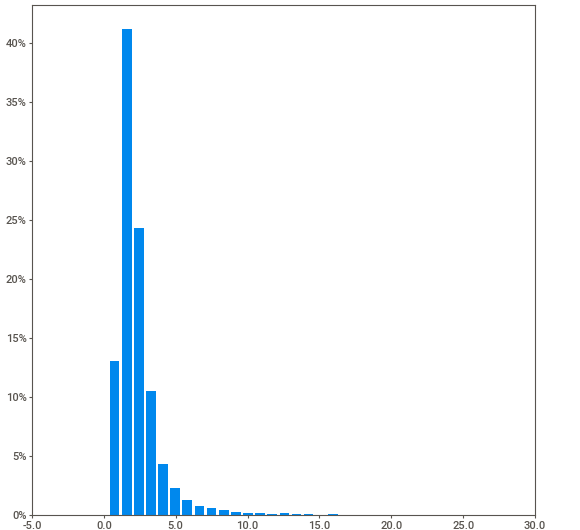
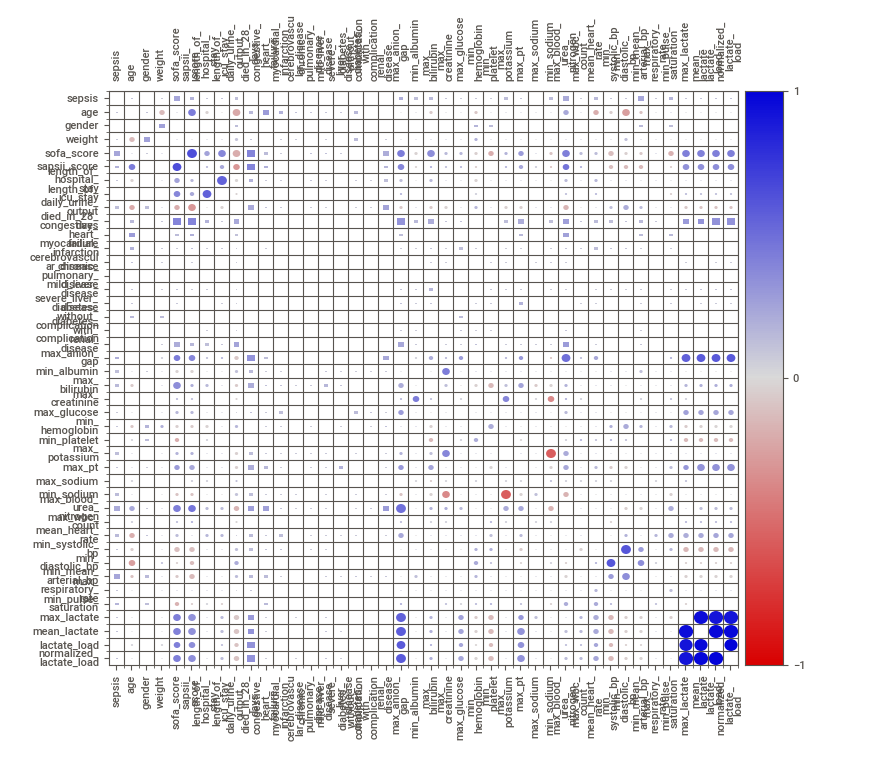
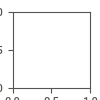

In [9]:
analysis = sv.analyze(data)
analysis.show_notebook()

* Using the `sweetviz` report above we can obtain summary statistics, and determine which variables are non-normal.  For these variaables, we can use Median and IQR instead of Mean and SD for our TableOne.
* However, for the purpose of replication, we will follow the format of Table 1 in the paper.

In [10]:
pd.set_option('display.max_rows', None)

categorical = ['gender','died_in_28_days','congestive_heart_failure','myocardial_infarction','cerebrovascular_disease','chronic_pulmonary_disease',
               'mild_liver_disease','severe_liver_disease','diabetes_without_complication','diabetes_with_complication','renal_disease']

groupby = 'sepsis'

nonnormal = ['length_of_hospital_stay','length_of_icu_stay','daily_urine_output','max_bilirubin','max_lactate','mean_lactate','lactate_load','normalized_lactate_load']

TableOne(data, categorical=categorical, groupby=groupby, nonnormal=nonnormal, pval=True)

Grouped by sepsis                                                                              
                                                      Missing                Overall                       0                      1 P-Value
n                                                                              17426                   11544                   5882        
age, mean (SD)                                              0            64.0 (15.9)             63.5 (15.8)            65.1 (15.9)  <0.001
gender, n (%)                           F                   0            6865 (39.4)             4298 (37.2)            2567 (43.6)  <0.001
                                        M                               10561 (60.6)             7246 (62.8)            3315 (56.4)        
weight, mean (SD)                                         534            83.7 (23.7)             84.3 (22.8)            82.6 (25.2)  <0.001
sofa_score, mean (SD)                                       0              7.2 (4.0)               6.7 (3.9)              8.3 (3.9)  <0.001
sapsii_score, mean (SD)                                     0            41.1 (14.7)             39.6 (14.5)            44.0 (14.8)  <0.001
length_of_hospital_stay, median [Q1,Q3]                     0         9.0 [5.0,15.0]          9.0 [5.0,14.0]         9.0 [6.0,16.0]  <0.001
length_of_icu_stay, median [Q1,Q3]                          0          3.0 [2.0,6.0]           3.0 [1.0,5.0]          3.0 [2.0,6.0]  <0.001
daily_urine_output, median [Q1,Q3]                        376  1555.0 [960.2,2360.0]  1630.0 [1050.0,2410.0]  1400.0 [800.0,2215.0]  <0.001
died_in_28_days, n (%)                  0                   0           14942 (85.7)            10182 (88.2)            4760 (80.9)  <0.001
                                        1                                2484 (14.3)             1362 (11.8)            1122 (19.1)        
congestive_heart_failure, n (%)         0.0                10           12680 (72.8)             8480 (73.5)            4200 (71.5)   0.005
                                        1.0                              4736 (27.2)             3060 (26.5)            1676 (28.5)        
myocardial_infarction, n (%)            0.0                10           14371 (82.5)             9359 (81.1)            5012 (85.3)  <0.001
                                        1.0                              3045 (17.5)             2181 (18.9)             864 (14.7)        
cerebrovascular_disease, n (%)          0.0                10           17071 (98.0)            11352 (98.4)            5719 (97.3)  <0.001
                                        1.0                                345 (2.0)               188 (1.6)              157 (2.7)        
chronic_pulmonary_disease, n (%)        0.0                10           16380 (94.1)            10908 (94.5)            5472 (93.1)  <0.001
                                        1.0                               1036 (5.9)               632 (5.5)              404 (6.9)        
mild_liver_disease, n (%)               0.0                10           17144 (98.4)            11384 (98.6)            5760 (98.0)   0.002
                                        1.0                                272 (1.6)               156 (1.4)              116 (2.0)        
severe_liver_disease, n (%)             0.0                10           17364 (99.7)            11507 (99.7)            5857 (99.7)   0.779
                                        1.0                                 52 (0.3)                33 (0.3)               19 (0.3)        
diabetes_without_complication, n (%)    0.0                10           14286 (82.0)             9466 (82.0)            4820 (82.0)   1.000
                                        1.0                              3130 (18.0)             2074 (18.0)            1056 (18.0)        
diabetes_with_complication, n (%)       0.0                10           17314 (99.4)            11474 (99.4)            5840

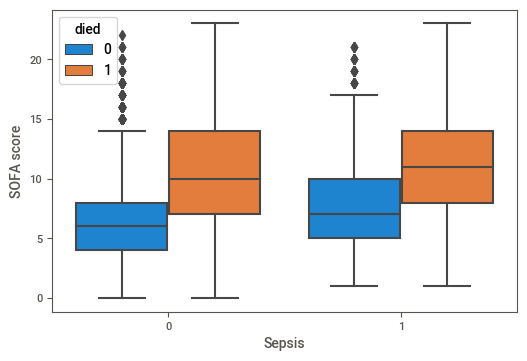

In [11]:
plot = sns.boxplot(x='sepsis', y='sofa_score', hue='died_in_28_days', data=data)
plot.set(xlabel = 'Sepsis', ylabel='SOFA score')
plot.legend(title='died', loc='upper left')

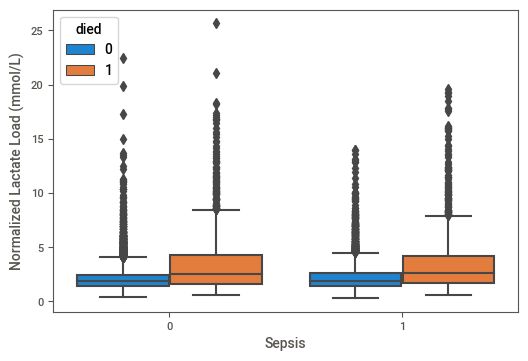

In [12]:
plot2 = sns.boxplot(x='sepsis', y='normalized_lactate_load', hue='died_in_28_days', data=data)
plot2.set(xlabel = 'Sepsis', ylabel='Normalized Lactate Load (mmol/L)')
plot2.legend(title='died', loc='upper left')